# Neuro4ML Coursework

Below, each question that needs a response will be marked by a ⚠️.

In this coursework, you will use a data set of spike trains recorded from monkey motor cortex while it was doing a task involving moving a pointer on a screen. The aim of this coursework is to decode the recorded velocity of the pointer from the neural data using a network of leaky integrate-and-fire neurons that take the recorded spikes as input and give sequences of velocities as outputs. You will train these networks using surrogate gradient descent. If you haven't already looked at it, a great starting point is Friedemann Zenke's [SPyTorch tutorial notebook 1](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb) (and the rest are worth looking at too).

In this coursework, we are following the general approach of the article ["Machine learning for neural decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020), but using a spiking neural network decoder instead of the statistical and artificial neural network models used in that paper. You can also have a look at the [GitHub repository for the paper](https://github.com/KordingLab/Neural_Decoding). In case you're interested, the data were originally recorded for the paper ["Population coding of conditional probability distributions in dorsal premotor cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6), but you do not need to read this paper to understand this coursework.

The general setup is illustrated in this figure:

![Cartoon of decoder setup](cartoon.png)

You are given an array of ``num_neurons`` spike trains in a variable ``spike_trains``. This variable is a Python list of numpy arrays, each numpy array has a different length and is the recorded times (in seconds) that the corresponding neuron fired a spike. You also have two additional arrays ``vel`` and ``vel_times`` where ``vel`` has shape ``(num_time_points, 2)`` and ``vel_times`` has has shape ``(num_time_points)``. The second axis of ``vel`` has length 2 corresponding to the x and y-components of the recorded velocity.

## Setting up

This section has some basics to get you started.

Let's start by importing some libraries you can make use of. You can solve all the task only using the imports below, but you are welcome to add your own.

In [94]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

You already have a copy of the raw data, but for your information, here is where the original can be downloaded.

In [95]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

## Task 1: Load and plot the data

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [96]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded

### Task 1A: Preprocess and compute basic statistics

In this task, you will preprocess the data, extract some basic statistics from it.

1. ⚠️ Whiten the recorded velocities (i.e. transform them so that their mean is 0 and standard deviation is 1).
2. ⚠️ Compute and print out the number of neurons and number of spikes recorded.
3. ⚠️ Compute and print out the duration of the experiment in seconds and/or minutes.
4. ⚠️ Compute and print out the sampling rate at which spikes were recorded (or find the information in the corresponding paper).
5. ⚠️ Compute and print out the sampling rate at which velocities were recorded (or find the information in the corresponding paper).

Note that the spikes and velocities were recorded with different equipment and so they have different sampling rates. Think about how you can estimate these sampling rates from the recorded data (or look it up in the paper).

In [97]:
#Task 1A
import numpy as np

# whiten velocities 
vel_mean = vel.mean(axis=0)        
vel_std = vel.std(axis=0)        

# to avoid divide-by-zero 
vel_std[vel_std == 0] = 1.0

vel_whitened = (vel - vel_mean) / vel_std
vel_raw = vel
vel = vel_whitened

# number of neurons + number of spikes 
num_neurons = len(spike_times)
total_spikes = sum(len(st) for st in spike_times)

# duration of experiment # using velocity timestamps
t_start_vel = float(vel_times[0])
t_end_vel = float(vel_times[-1])
duration_vel = t_end_vel - t_start_vel

# from spikes (max spike time across all neurons)
max_spike_time = 0.0
for st in spike_times:
    if len(st) > 0:
        max_st = float(st.max())
        if max_st > max_spike_time:
            max_spike_time = max_st

# spike sampling rate
# spike times are event-based, but timestamps are quantised to an underlying sampling rate.
# We estimate it from the minimum positive difference between consecutive spike times.
all_spikes_list = [st for st in spike_times if len(st) > 0]

if len(all_spikes_list) > 0:
    all_spikes = np.concatenate(all_spikes_list)
    all_spikes_sorted = np.sort(all_spikes)

    # differences between consecutive spike times
    dt_spikes = np.diff(all_spikes_sorted)

    # only considering strictly positive differences
    dt_spikes = dt_spikes[dt_spikes > 0]

    if len(dt_spikes) > 0:
        spike_time_resolution = dt_spikes.min()
        fs_spikes = 1.0 / spike_time_resolution
    else:
        spike_time_resolution = np.nan
        fs_spikes = np.nan
else:
    spike_time_resolution = np.nan
    fs_spikes = np.nan


dt_vel = np.diff(vel_times)
mean_dt_vel = dt_vel.mean()
std_dt_vel = dt_vel.std()
fs_vel = 1.0 / mean_dt_vel if mean_dt_vel != 0 else np.nan # velocity sampling rate 

print("Task 1A")
print(f"Number of neurons: {num_neurons}")
print(f"Total number of spikes: {total_spikes}")

print("\nDuration of experiment ")
print(f"From velocity timestamps: {duration_vel:.3f} s ({duration_vel/60:.2f} min)")
print(f"From spike timestamps (max spike time): {max_spike_time:.3f} s ({max_spike_time/60:.2f} min)")

print("\nSpike sampling ")
print(f"Estimated spike time resolution (min Δt between spikes): {spike_time_resolution*1e3:.3f} ms")
print(f"Approximate spike sampling rate: {fs_spikes/1e3:.2f} kHz")

print("\nVelocity sampling ")
print(f"Mean Δt between velocity samples: {mean_dt_vel*1e3:.3f} ms")
print(f"Std of Δt between velocity samples: {std_dt_vel*1e3:.3f} ms")
print(f"Velocity sampling rate: {fs_vel:.2f} Hz")

print("\nWhitened parameters")
print(f"Velocity mean (vx, vy): {vel_mean}")
print(f"Velocity std  (vx, vy): {vel_std}")


Task 1A
Number of neurons: 52
Total number of spikes: 1480032

Duration of experiment 
From velocity timestamps: 3066.990 s (51.12 min)
From spike timestamps (max spike time): 3071.334 s (51.19 min)

Spike sampling 
Estimated spike time resolution (min Δt between spikes): 0.033 ms
Approximate spike sampling rate: 30.00 kHz

Velocity sampling 
Mean Δt between velocity samples: 10.000 ms
Std of Δt between velocity samples: 0.000 ms
Velocity sampling rate: 100.00 Hz

Whitened parameters
Velocity mean (vx, vy): [-0.00068218 -0.00143839]
Velocity std  (vx, vy): [7.63293881 7.71015213]


In [98]:
print("Velocity mean after whitening:", vel.mean(axis=0).round(6))
print("Velocity std after whitening:", vel.std(axis=0).round(6))


Velocity mean after whitening: [-0.  0.]
Velocity std after whitening: [1. 1.]


### Task 1B: Plot the data

In this task, you will plot the data to get a feeling for what it is like (an important step in any modelling).

1. ⚠️ Plot the spike times as a raster plot (black dots at x-coordinates the time of the spike, and y-coordinates the index of the neuron). Plot this both for the whole data set and for the period from 1000 to 1010 seconds.
2. ⚠️ Plot the x- and y-coordinates of the velocities. Plot this both for the whole data set and for the same period as above for the spikes.
3. ⚠️ Compute the mean firing rate (number of spikes per second) for each neuron and display as a bar chart.
4. ⚠️ Plot the velocities as a curve in (x, y) space, emphasising the part of the velocity curve for the period above.

You can use the template below to get you started.

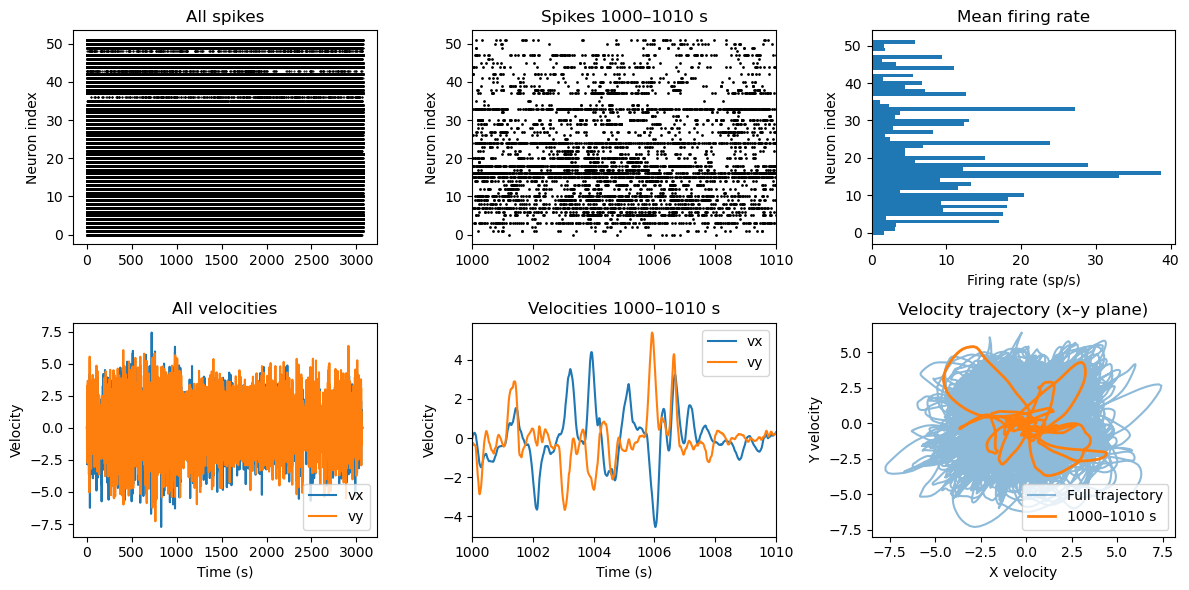

Task 1B
Mean firing rate across neurons: 9.28 sp/s
Std of firing rates: 8.83 sp/s
Min firing rate: 0.14 sp/s
Max firing rate: 38.67 sp/s


In [99]:
#Task 1B
# time window for zoomed-in plots
t_start = 1000.0
t_end   = 1010.0

# duration of the experiment for firing rates
duration = vel_times[-1] - vel_times[0]

plt.figure(figsize=(12, 6))

#raster
ax = plt.subplot(231)
for i, st in enumerate(spike_times):
    if len(st) == 0:
        continue
    # y = neuron index, x = spike time
    plt.plot(st, i * np.ones_like(st), '.', markersize=1, color='k')

plt.ylabel('Neuron index')
plt.title('All spikes')

#plot x y velocities
plt.subplot(234, sharex=ax)
plt.plot(vel_times, vel[:, 0], label='vx')
plt.plot(vel_times, vel[:, 1], label='vy')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('All velocities')
plt.legend(loc='best')

# plot spike in window
ax = plt.subplot(232)
for i, st in enumerate(spike_times):
    if len(st) == 0:
        continue
    mask = (st >= t_start) & (st <= t_end)
    if np.any(mask):
        plt.plot(st[mask], i * np.ones(mask.sum()), '.', markersize=2, color='k')

plt.xlim(t_start, t_end)
plt.ylabel('Neuron index')
plt.title(f'Spikes {t_start:.0f}–{t_end:.0f} s')

#plot velocities in window
plt.subplot(235, sharex=ax)
vel_mask = (vel_times >= t_start) & (vel_times <= t_end)
plt.plot(vel_times[vel_mask], vel[vel_mask, 0], label='vx')
plt.plot(vel_times[vel_mask], vel[vel_mask, 1], label='vy')
plt.xlim(t_start, t_end)
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title(f'Velocities {t_start:.0f}–{t_end:.0f} s')
plt.legend(loc='best')

#mean firing rate for each neuron
plt.subplot(233)
firing_rates = np.array([len(st) / duration for st in spike_times])  # spikes per second
plt.barh(range(len(spike_times)), firing_rates, height=1)
plt.xlabel('Firing rate (sp/s)')
plt.ylabel('Neuron index')
plt.title('Mean firing rate')

#velocity curve
plt.subplot(236)
# full curve
plt.plot(vel[:, 0], vel[:, 1], label='Full trajectory', alpha=0.5)


plt.plot(vel[vel_mask, 0], vel[vel_mask, 1],
         label=f'{t_start:.0f}–{t_end:.0f} s', linewidth=2)

plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.title('Velocity trajectory (x–y plane)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


mean_fr = np.mean(firing_rates)
std_fr  = np.std(firing_rates)
min_fr  = np.min(firing_rates)
max_fr  = np.max(firing_rates)

print("Task 1B")
print(f"Mean firing rate across neurons: {mean_fr:.2f} sp/s")
print(f"Std of firing rates: {std_fr:.2f} sp/s")
print(f"Min firing rate: {min_fr:.2f} sp/s")
print(f"Max firing rate: {max_fr:.2f} sp/s")


In [100]:
# plt.figure(figsize=(12, 5))

# # Plot all spikes
# ax = plt.subplot(231)
# # ...
# plt.ylabel('Neuron index')
# # Plot all x- and y- components of the velocities
# plt.subplot(234, sharex=ax)
# # ...
# plt.xlabel('Time (s)')
# plt.ylabel('velocity')
# plt.legend(loc='best')
# # Plot spikes at times t=1000 to t=1010
# ax = plt.subplot(232)
# # ...
# # Plot velocities at times t=1000 to t=1010
# plt.subplot(235, sharex=ax)
# plt.xlabel('Time (s)')

# # Compute firing rates for each neuron and plot as a histogram
# plt.subplot(233)
# firing_rates = ...
# plt.barh(range(len(spike_times)), firing_rates, height=1)
# plt.xlabel('Firing rate (sp/s)')
# plt.ylabel('Neuron index')

# # Plot all velocities as points in (x, y)-plane as a continuous curve
# # Emphasise the region from t=1000 to t=1010 with a different colour
# plt.subplot(236)
# # ...
# plt.xlabel('X velocity')
# plt.ylabel('Y velocity')

# plt.tight_layout();

## Task 2: Divide data into test/train and batches

In this section, you will divide the data up into non-overlapping test, train and (optionally) validation sets.

### Task 2A: Why not just use continuous time ranges?

In the Glaser et al. paper linked to above, they simply divide the range so that the first 70% of the data is used for training, the next 15% for validation and the last 15% for testing. This is a standard thing to do.

1. ⚠️ Compute the speeds from the velocity components, plot them and compute some statistics to show why this is a bad idea for this dataset. To make the plot clear, you might want to take averages over some window rather than plotting every point.

Task 2A
Total duration: 3066.99 s
Train split (0-70%): t = 0 to 2146.89 s
Val split (70-85%): t = 2146.89 to 2606.94 s
Test split (85-100%): t = 2606.94 to 3066.99 s

Speed stats by split
Training set:
  Mean speed: 1.040
  Std speed:  1.017
  Min speed:  0.000
  Max speed:  8.406

Validation set:
  Mean speed: 0.929
  Std speed:  0.916
  Min speed:  0.000
  Max speed:  6.525

Test set:
  Mean speed: 0.955
  Std speed:  0.919
  Min speed:  0.000
  Max speed:  6.392


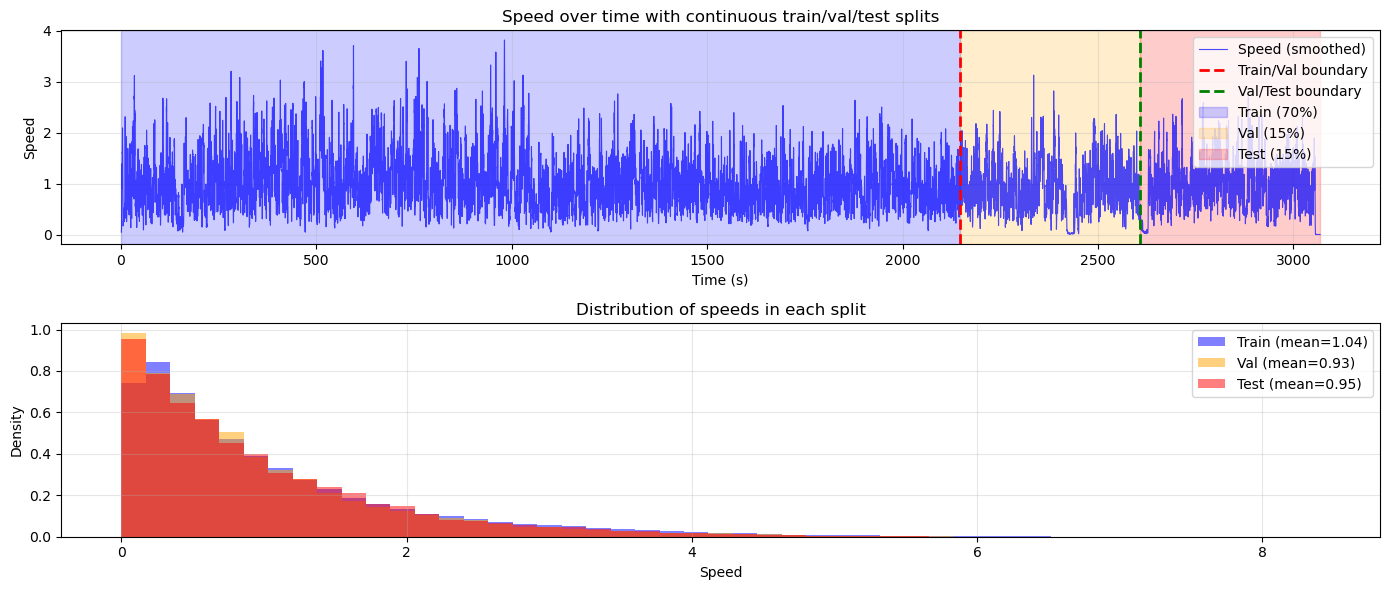

Continuous time-based splits are problematic because neural activity and behaviour
can drift over time (e.g. the monkey gets tired or the task difficulty changes).
This causes train/validation/test sets to come from different distributions,
leading to poor generalisation performance.


In [101]:
#Task 2A
# speed = sqrt(vx^2 + vy^2)
speed = np.sqrt(vel[:, 0]**2 + vel[:, 1]**2)

# smooth speed using a moving average for clearer visualisation
# window size for averaging = 1s
window_size = int(fs_vel * 1.0)  # 1 second window
if window_size < 1:
    window_size = 1

#convolution
def moving_average(data, window):
    """Compute moving average with given window size."""
    if window < 1:
        return data
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='same')

speed_smoothed = moving_average(speed, window_size)

# define the split points 
total_duration = duration_vel
train_end = 0.70 * total_duration
val_end = 0.85 * total_duration  # 0.70 + 0.15

# convert to indices
train_end_idx = np.searchsorted(vel_times, vel_times[0] + train_end)
val_end_idx = np.searchsorted(vel_times, vel_times[0] + val_end)

# Compute statistics for each split
speed_train = speed[:train_end_idx]
speed_val = speed[train_end_idx:val_end_idx]
speed_test = speed[val_end_idx:]

print(f"Task 2A")
print(f"Total duration: {total_duration:.2f} s")
print(f"Train split (0-70%): t = 0 to {train_end:.2f} s")
print(f"Val split (70-85%): t = {train_end:.2f} to {train_end + 0.15*total_duration:.2f} s")
print(f"Test split (85-100%): t = {train_end + 0.15*total_duration:.2f} to {total_duration:.2f} s")

print("\nSpeed stats by split")
print(f"Training set:")
print(f"  Mean speed: {speed_train.mean():.3f}")
print(f"  Std speed:  {speed_train.std():.3f}")
print(f"  Min speed:  {speed_train.min():.3f}")
print(f"  Max speed:  {speed_train.max():.3f}")

print(f"\nValidation set:")
print(f"  Mean speed: {speed_val.mean():.3f}")
print(f"  Std speed:  {speed_val.std():.3f}")
print(f"  Min speed:  {speed_val.min():.3f}")
print(f"  Max speed:  {speed_val.max():.3f}")

print(f"\nTest set:")
print(f"  Mean speed: {speed_test.mean():.3f}")
print(f"  Std speed:  {speed_test.std():.3f}")
print(f"  Min speed:  {speed_test.min():.3f}")
print(f"  Max speed:  {speed_test.max():.3f}")

#plot the speed over time with split boundaries
plt.figure(figsize=(14, 6))

#main plot: speed over time
ax1 = plt.subplot(211)
plt.plot(vel_times, speed_smoothed, 'b-', linewidth=0.8, alpha=0.7, label='Speed (smoothed)')
plt.axvline(vel_times[0] + train_end, color='r', linestyle='--', linewidth=2, label='Train/Val boundary')
plt.axvline(vel_times[0] + train_end + 0.15*total_duration, color='g', linestyle='--', linewidth=2, label='Val/Test boundary')

# shade the regions
plt.axvspan(vel_times[0], vel_times[0] + train_end, alpha=0.2, color='blue', label='Train (70%)')
plt.axvspan(vel_times[0] + train_end, vel_times[0] + train_end + 0.15*total_duration, alpha=0.2, color='orange', label='Val (15%)')
plt.axvspan(vel_times[0] + train_end + 0.15*total_duration, vel_times[-1], alpha=0.2, color='red', label='Test (15%)')

plt.xlabel('Time (s)')
plt.ylabel('Speed')
plt.title('Speed over time with continuous train/val/test splits')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# histogram of speeds in each split
ax2 = plt.subplot(212)
bins = np.linspace(0, speed.max(), 50)
plt.hist(speed_train, bins=bins, alpha=0.5, label=f'Train (mean={speed_train.mean():.2f})', color='blue', density=True)
plt.hist(speed_val, bins=bins, alpha=0.5, label=f'Val (mean={speed_val.mean():.2f})', color='orange', density=True)
plt.hist(speed_test, bins=bins, alpha=0.5, label=f'Test (mean={speed_test.mean():.2f})', color='red', density=True)
plt.xlabel('Speed')
plt.ylabel('Density')
plt.title('Distribution of speeds in each split')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Continuous time-based splits are problematic because neural activity and behaviour")
print("can drift over time (e.g. the monkey gets tired or the task difficulty changes).")
print("This causes train/validation/test sets to come from different distributions,")
print("leading to poor generalisation performance.")

### Task 2B: use equally distributed segments for training, test and validation

1. ⚠️ Divide the data up into segments and use some fraction of these segments for training, test and validation, ensuring these segments do not overlap but that they are equally distributed throughout the data.
2. ⚠️ Write a generator function (see below) ``batched_data`` that iterates over your data in randomly ordered segments of a given length, returning it in batches. The function should have arguments that determine the fraction of the data to use, the simulation time step that will be used, the length (in seconds) of each batch, and the batch size (you may add additional arguments if you wish). The function should return a pair of arrays ``(x, y)``. The array ``x`` has shape ``(batch_size, num_neurons, num_time_points)`` containing the spike times as an array where a zero indicates no spike and 1 indicates a spike. Here ``num_time_points`` is the number of time points in the batch measured at the sampling rate of the simulation time step, not the number of time points in the data as a whole, nor at the spike or velocity sampling rate. The array ``y`` has shape ``(batch_size, 2, num_time_points)`` containing the velocities at the same time points as the spikes. You will need to use some sort of interpolation to get the velocities at these times.
3. ⚠️ Plot a sample of spike times and velocities for a random batch of length 1 second and ``batch_size=4``.

#### Note on generator functions

Generator functions are an advanced feature of Python that makes it easy to iterate over complicated datasets. The general syntax is just a standard function that uses the keyword ``yield`` instead of ``return`` to return data, which allows it to return data multiple times. You can iterate over the values returned by a generator function instead of just calling it. Here's an example:

In [102]:
def gimme_some_multiples(n):
    yield n*1
    yield n*2
    yield n*3

for x in gimme_some_multiples(3):
    print(x)

3
6
9


And another:

In [103]:
def gimme_some_more_multiples(n, how_many):
    for i in range(how_many):
        yield n*(i+1)

for x in gimme_some_more_multiples(5, 4):
    print(x)

5
10
15
20


#### Template

You can use the following template but you may want to define some additional helper functions to simplify your code and that you can re-use later.

In [104]:
# # Template

# # Set up training / validation / testing ranges
# # ...

# # Generator function that yields batches
# def batched_data(range_to_use, dt=1e-3, length=1, batch_size=64):
#   pass # ...
#   for batch_idx in range(num_batches):
#     x = torch.zeros((batch_size, num_neurons, num_time_points))
#     y = torch.zeros((batch_size, 2, num_time_points))
#     for b in range(batch_size):
#       pass # ...
#     yield x, y

# # Plot a sample of data

# x, y = next(batched_data(...)) # this just gets the first item of an iterable

# plt.figure(figsize=(12, 5))
# for b in range(4):
#   # Plot spikes for this batch index
#   ax = plt.subplot(2, 4, b+1)
#   # ...
#   plt.ylabel('Neuron index')
#   plt.title(f'Batch index {b}')
#   # Plot velocities for this batch index
#   plt.subplot(2, 4, b+5, sharex=ax)
#   plt.xlabel('Time index')
#   plt.ylabel('velocity')
#   if b==0:
#     plt.legend(loc='best')
# plt.tight_layout();

Total duration: 3066.99 s (51.12 min)
Segment length: 1.0 s
Total segments: 3066

Segment split:
  Train: 2146 segments (2146.0s, 70%)
  Val:   459 segments (459.0s, 15%)
  Test:  461 segments (461.0s, 15%)

Segment ranges created:
  train_range: 2146 time windows
  val_range:   459 time windows
  test_range:  461 time windows

Sample batch shapes:
  x (spikes): torch.Size([4, 52, 1000])
  y (velocities): torch.Size([4, 2, 1000])


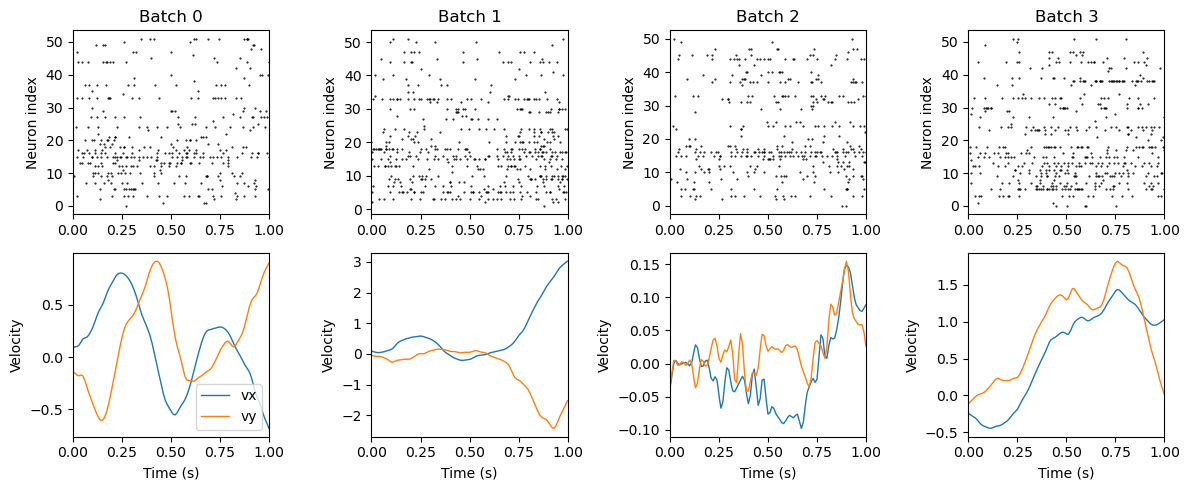

In [105]:
#Task 2B
# Use 1 second segments (matches batch length)
segment_length = 1.0  # seconds

#calculate segment parameters
t_start_global = vel_times[0]
t_end_global = vel_times[-1]
total_duration = t_end_global - t_start_global
num_segments = int(total_duration // segment_length)

print(f"Total duration: {total_duration:.2f} s ({total_duration/60:.2f} min)")
print(f"Segment length: {segment_length} s")
print(f"Total segments: {num_segments}")

# randomly shuffle segment indices and split 70%/15%/15%
np.random.seed(42)  # For reproducibility
segment_indices = np.arange(num_segments)
np.random.shuffle(segment_indices)

# split fractions
train_fraction = 0.70
val_fraction = 0.15
test_fraction = 0.15

n_train = int(num_segments * train_fraction)
n_val = int(num_segments * val_fraction)
n_test = num_segments - n_train - n_val

train_idx = segment_indices[:n_train]
val_idx = segment_indices[n_train:n_train + n_val]
test_idx = segment_indices[n_train + n_val:]

print(f"\nSegment split:")
print(f"  Train: {n_train} segments ({n_train * segment_length:.1f}s, {train_fraction*100:.0f}%)")
print(f"  Val:   {n_val} segments ({n_val * segment_length:.1f}s, {val_fraction*100:.0f}%)")
print(f"  Test:  {n_test} segments ({n_test * segment_length:.1f}s, {test_fraction*100:.0f}%)")

# create segment start times
segment_starts = t_start_global + np.arange(num_segments) * segment_length
segment_ends = segment_starts + segment_length

# create ranges for each split
train_range = [(segment_starts[i], segment_ends[i]) for i in train_idx]
val_range = [(segment_starts[i], segment_ends[i]) for i in val_idx]
test_range = [(segment_starts[i], segment_ends[i]) for i in test_idx]

print(f"\nSegment ranges created:")
print(f"  train_range: {len(train_range)} time windows")
print(f"  val_range:   {len(val_range)} time windows")
print(f"  test_range:  {len(test_range)} time windows")


#Generator Function

def batched_data(range_to_use, dt=1e-3, length=1.0, batch_size=64, max_num_batches=None):
    """
    Generator that yields (x, y) batches from randomly ordered segments.
    
    Parameters:
    -----------
    range_to_use : list of tuples
        List of (start_time, end_time) tuples defining valid segments
    dt : float
        Simulation time step in seconds
    length : float
        Length of each batch in seconds
    batch_size : int
        Number of samples per batch
    max_num_batches : int or None
        Maximum number of batches to yield (None = infinite loop)
    
    Yields:
    -------
    x : torch.Tensor
        Spike data, shape (batch_size, num_neurons, num_time_points)
        Values are 0 (no spike) or 1 (spike)
    y : torch.Tensor
        Velocity data, shape (batch_size, 2, num_time_points)
        Interpolated velocities at same time points as spikes
    """
    num_time_points = int(np.round(length / dt))
    time_grid = np.arange(num_time_points) * dt
    
    batch_idx = 0
    while True:
        if max_num_batches is not None and batch_idx >= max_num_batches:
            break
            
        x = torch.zeros((batch_size, num_neurons, num_time_points), dtype=torch.float32)
        y = torch.zeros((batch_size, 2, num_time_points), dtype=torch.float32)
        
        for b in range(batch_size):
            # randomly select a segment
            seg_idx = np.random.randint(len(range_to_use))
            seg_start, seg_end = range_to_use[seg_idx]
            
            # randomly select start time within segment
            available_time = seg_end - seg_start - length
            if available_time <= 0:
                batch_start = seg_start
            else:
                batch_start = seg_start + np.random.uniform(0, available_time)
            
            batch_end = batch_start + length
            
            # x = spike trains as 0,1 array 
            for neuron_idx, st in enumerate(spike_times):
                # find spikes in this time window
                spikes_in_window = st[(st >= batch_start) & (st < batch_end)]
                
                if len(spikes_in_window) > 0:
                    # convert spike times to indices
                    spike_indices = ((spikes_in_window - batch_start) / dt).astype(int)
                    #clip to valid range
                    spike_indices = spike_indices[spike_indices < num_time_points]
                    x[b, neuron_idx, spike_indices] = 1.0
            
            # y = interpolate velocities to match spike times 
            batch_time_points = batch_start + time_grid
            
            #gt velocity data around this window (with buffer for interpolation)
            vel_mask = (vel_times >= batch_start - 1) & (vel_times <= batch_end + 1)
            vel_times_local = vel_times[vel_mask]
            vel_local = vel[vel_mask, :]
            
            if len(vel_times_local) > 1:
                # Interpolate each velocity component
                for dim in range(2):
                    y[b, dim, :] = torch.from_numpy(
                        np.interp(batch_time_points, vel_times_local, vel_local[:, dim])
                    ).float()
        
        yield x, y
        batch_idx += 1



#get one batch from training segments
dt_sim = 1e-3
batch_length = 1.0
sample_batch_size = 4

x_batch, y_batch = next(batched_data(train_range,
                                     dt=dt_sim,
                                     length=batch_length,
                                     batch_size=sample_batch_size))

print(f"\nSample batch shapes:")
print(f"  x (spikes): {x_batch.shape}")
print(f"  y (velocities): {y_batch.shape}")

#convert to numpy for plotting
x_np = x_batch.numpy()
y_np = y_batch.numpy()

num_time_points = x_np.shape[2]
time_indices = np.arange(num_time_points)
time_seconds = time_indices * dt_sim

#plot
plt.figure(figsize=(12, 5))

for b in range(sample_batch_size):
    # plot spikes for this batch index 
    ax = plt.subplot(2, 4, b + 1)
    for neuron_idx in range(num_neurons):
        spike_idx = np.where(x_np[b, neuron_idx, :] > 0.5)[0]
        if spike_idx.size > 0:
            ax.plot(time_seconds[spike_idx],
                    neuron_idx * np.ones_like(spike_idx),
                    'k.', markersize=1)
    ax.set_ylabel('Neuron index')
    ax.set_title(f'Batch {b}')
    ax.set_xlim([0, batch_length])
    
    # plot velocities for this batch index
    plt.subplot(2, 4, b + 5, sharex=ax)
    plt.plot(time_seconds, y_np[b, 0, :], 'C0', label='vx', linewidth=1)
    plt.plot(time_seconds, y_np[b, 1, :], 'C1', label='vy', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity')
    if b == 0:
        plt.legend(loc='best')

plt.tight_layout()
plt.show()



## Task 3: Spiking neural network model

In this task, you will write code to simulate a spiking neural network that can be trained using surrogate gradient descent, as in lectures. The neuron model will have some extra features beyond what you have seen in lectures and in the SPyTorch tutorial.

### Surrogate gradient descent spike function

Below is the code for the surrogate gradient descent function from lectures. You can use it as is, although note that there is a hyperparameter (scale) that you can experiment with if you choose.

In [106]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

### Task 3A: Single layer simulation code

1. ⚠️ Write modular code to simulate a layer of leaky integrate-and-fire spiking neurons compatible with autodifferentiation with PyTorch. The new feature compared to what you have seen before is that the time constant parameter $\tau$ should be different for each neuron, and be trainable.

You can write your simulator as a function or class. My recommendation is to derive from the ``nn.Module`` class of PyTorch, but you can do it how you like. The code should accept an input batch of spikes ``x`` of shape ``(batch_size, num_input_neurons, num_time_points)`` and values 0 or 1 (as in the ``batched_data`` generator function above). The code should have the option to produce either spiking or non-spiking output. In both cases, the output should be an array ``y`` of shape ``(batch_size, num_output_neurons, num_time_points)``. In the case of spiking output, the values of ``y`` should be 0s and 1s, and in the case of non-spiking output they should be the membrane potential values. You may also want to write an additional class to handle multiple layers of spiking neural networks for subsequent tasks.

Your code should include initialisation of the weight matrices and time constants, and add additional hyperparameters for this initialisation. I used a spread of time constants from 20-100 ms for spiking neurons and from 200 to 1000 ms for non-spiking neurons and it worked OK, but I didn't do an extensive hyperparameter search and you can probably improve on this.

<!-- I would recommend approaching this and the following sections as follows:

1. Write simulation code for a single layer, non-spiking neural network first. This code is simpler and will train fast (under 3 minutes on Colab). Attempt as much of the remaining tasks as possible using only this.
2. Add the ability for spiking and test that your code produces reasonable output but don't try to train it yet.
3. Add the ability to plot spiking hidden layers and try to get a reasonable initialisation of the network.
4. Start training the spiking neural network. Your final run will probably take a long time to train but you should build up to that by seeing how well the training curves improve for fewer epochs, batch sizes, etc. -->

You can use the template below if you want to use the class-based approach.

You may also find it useful to write a class that chains together a group of layers for later parts of the courseowrk.

In [107]:
# class SNNLayer(nn.Module):
#   def __init__(self, n_in, n_out, spiking=True):
#     super(SNNLayer, self).__init__()
#     self.n_in = n_in
#     self.n_out = n_out
#     self.spiking = spiking
#     # Store weights as a trainable parameter
#     self.w = nn.Parameter(torch.ones((n_in, n_out)))
#     # ...

#   def forward(self, x):
#     batch_size, num_neurons, num_time_points = x.shape
#     # ...
#     return y

In [108]:
#Task 3A: Single layer simulation code
class SNNLayer(nn.Module):
   
    def __init__(self, n_in, n_out, dt=1e-3, spiking=True, 
                 tau_min=20e-3, tau_max=100e-3):
        super(SNNLayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.dt = dt
        self.spiking = spiking
        
        # trainable weights
        self.w = nn.Parameter(torch.randn(n_in, n_out) * np.sqrt(2.0 / n_in))
        
        # trainable time constants (stored as log for positivity)
        tau_init = torch.rand(n_out) * (tau_max - tau_min) + tau_min
        self.log_tau = nn.Parameter(torch.log(tau_init))
        
    def get_tau(self):
        """Get time constants (ensure positive)."""
        return torch.exp(self.log_tau)
    
    def forward(self, x):
        """
        Forward pass through LIF layer.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input spikes, shape (batch_size, n_in, num_time_points)
            Values should be 0 or 1
        
        Returns:
        --------
        y : torch.Tensor
            Output, shape (batch_size, n_out, num_time_points)
            - If spiking=True: 0s and 1s (spikes)
            - If spiking=False: membrane potentials
        """
        batch_size, n_in, num_time_points = x.shape
        assert n_in == self.n_in, f"Expected {self.n_in} input neurons, got {n_in}"
        
        # get time constants and decay factor
        tau = self.get_tau()
        alpha = torch.exp(-self.dt / tau)
        
        # initialize membrane potential
        v = torch.zeros(batch_size, self.n_out, device=x.device, dtype=x.dtype)
        outputs = torch.zeros(batch_size, self.n_out, num_time_points, 
                            device=x.device, dtype=x.dtype)
        
        # simulate over time
        for t in range(num_time_points):
            x_t = x[:, :, t]  # (batch_size, n_in)
            I = torch.matmul(x_t, self.w)  # (batch_size, n_out)
            
            # leaky integration: v(t+1) = α·v(t) + I(t)
            v = alpha * v + I
            
            if self.spiking:
                # generate spikes using surrogate gradient
                s = surrogate_heaviside(v - 1.0)
                outputs[:, :, t] = s
                v = v * (1 - s) #reset v
            else:
                # non-spiking: output membrane potential
                outputs[:, :, t] = v
        
        return outputs

### Task 3B: Verify your code

You will verify your code by simulating a network consisting of:

* One (non-simulated) input neuron firing at a constant rate of 50 sp/s for a total duration of 1 second simulated with a time step of ``dt=1*ms``.
* Two simulated, spiking neurons which each receive spikes from the input neuron with a weight of 0.5. The two simulated neurons should have time constants of 20 ms and 100 ms.

You should:

1. ⚠️ Run the simulation, recording the membrane potentials and spike times of the simulated neurons.
2. ⚠️ Plot the membrane potentials and spike times of the simulated neurons. Print the spike counts of the neurons. The first neuron should not fire any spikes.
3. ⚠️ Write down an analytic solution for the first simulated neuron (that doesn't fire any spikes).
4. ⚠️ Plot your analytic solution on the same graph as the simulated one to show that it is approximately equal.

Task 3B: Verification of PyTorch SNNLayer

Input: 50 spikes at 50.0 Hz
Spike interval: 20 time steps (20.0 ms)

Neuron time constants: [20.      99.99999] ms
Weights: [0.5 0.5]

Simulation Results:
  Neuron 0 (τ=20ms): 0 spikes
  Neuron 1 (τ=100ms): 16 spikes

Verification of Neuron 0 (τ=20ms):
  MSE (simulated vs analytical): 5.88e-14
  Max absolute difference: 3.87e-07
  Match: PASS



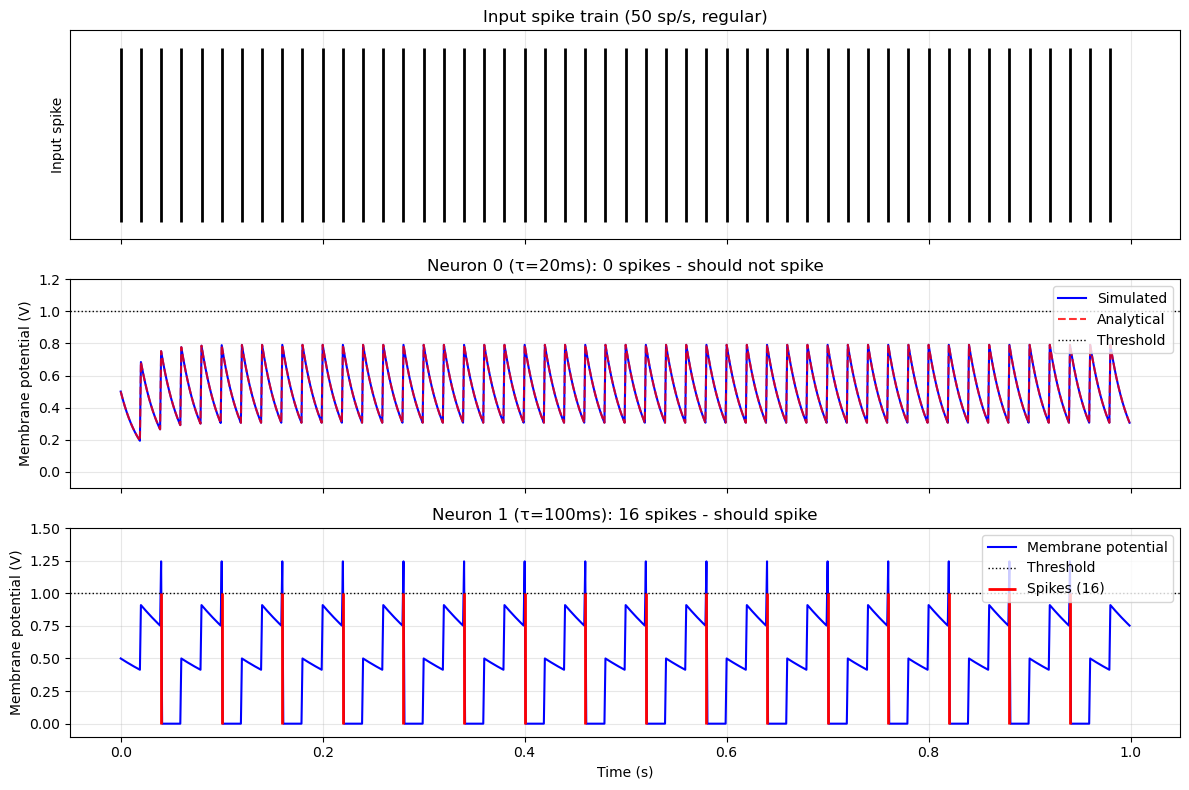

In [109]:
#Task 3B: Verify PyTorch SNNLayer Implementation
import numpy as np
import matplotlib.pyplot as plt
import torch

print("Task 3B: Verification of PyTorch SNNLayer\n")

# Simulation parameters
dt = 1e-3  # 1 ms time step
duration = 1.0  # 1 second
num_time_points = int(duration / dt)
time = np.arange(num_time_points) * dt

#Create input spike train: 50 sp/s regular spikes 
rate = 50.0  # Hz
spike_interval = int(1.0 / (rate * dt))  # spike every 20 time steps
input_spikes = np.zeros(num_time_points)
input_spikes[::spike_interval] = 1.0

print(f"Input: {int(input_spikes.sum())} spikes at {rate} Hz")
print(f"Spike interval: {spike_interval} time steps ({spike_interval * dt * 1000:.1f} ms)\n")

# Convert to PyTorch: shape (batch_size=1, n_in=1, num_time_points)
x_input = torch.from_numpy(input_spikes).float().unsqueeze(0).unsqueeze(0)

#Create SNNLayer with 2 neurons (tau=20ms and tau=100ms)
layer = SNNLayer(n_in=1, n_out=2, dt=dt, spiking=True,
                tau_min=20e-3, tau_max=100e-3)

# Manually set parameters for verification
with torch.no_grad():
    # Set time constants to exactly 20ms and 100ms
    layer.log_tau[0] = torch.log(torch.tensor(20e-3))
    layer.log_tau[1] = torch.log(torch.tensor(100e-3))
    
    # Set weights to 0.5 for both neurons
    layer.w[:, :] = 0.5

tau_values = layer.get_tau().detach().numpy()
print(f"Neuron time constants: {tau_values * 1000} ms")
print(f"Weights: {layer.w.detach().numpy().flatten()}\n")

#Run simulation with membrane potential recording

class SNNLayerWithRecording(SNNLayer):
    """Extended SNNLayer that records membrane potentials."""
    def forward(self, x):
        batch_size, n_in, num_time_points = x.shape
        
        tau = self.get_tau()
        alpha = torch.exp(-self.dt / tau)
        
        v = torch.zeros(batch_size, self.n_out, device=x.device, dtype=x.dtype)
        outputs = torch.zeros(batch_size, self.n_out, num_time_points, 
                            device=x.device, dtype=x.dtype)
        v_hist = torch.zeros(batch_size, self.n_out, num_time_points,
                           device=x.device, dtype=x.dtype)
        
        for t in range(num_time_points):
            x_t = x[:, :, t]
            I = torch.matmul(x_t, self.w)
            
            # Leaky integration with direct spike addition
            v = alpha * v + I
            
            # Record membrane potential before spike/reset
            v_hist[:, :, t] = v
            
            if self.spiking:
                s = surrogate_heaviside(v - 1.0)
                outputs[:, :, t] = s
                # 
                v = v * (1 - s) # Reset v to 0
        
        return outputs, v_hist

# Create recording layer with same parameters
layer_record = SNNLayerWithRecording(n_in=1, n_out=2, dt=dt, spiking=True)
with torch.no_grad():
    layer_record.log_tau[0] = torch.log(torch.tensor(20e-3))
    layer_record.log_tau[1] = torch.log(torch.tensor(100e-3))
    layer_record.w[:, :] = 0.5

# Run simulation
with torch.no_grad():
    spikes_out, v_membrane = layer_record(x_input)

# Extract results
spikes_out = spikes_out[0].numpy()  # shape: (2, num_time_points)
v_membrane = v_membrane[0].numpy()  # shape: (2, num_time_points)

# Count spikes
spike_counts = [int(spikes_out[0].sum()), int(spikes_out[1].sum())]
print(f"Simulation Results:")
print(f"  Neuron 0 (τ=20ms): {spike_counts[0]} spikes")
print(f"  Neuron 1 (τ=100ms): {spike_counts[1]} spikes\n")

#Analytical solution for Neuron 0 (no spikes)
# For v(t+1) = alpha * v(t) + w * s_in(t)
# Solution: v[k] = sum over all input spike times t_s <= k of w * alpha^(k - t_s)

tau_0 = 20e-3
alpha_0 = np.exp(-dt / tau_0)
w = 0.5

spike_indices = np.where(input_spikes > 0.5)[0]
v_analytical = np.zeros(num_time_points)

for k in range(num_time_points):
    # Find all input spikes up to time k
    past_spikes = spike_indices[spike_indices <= k]
    if len(past_spikes) > 0:
        # Sum contributions from all past spikes
        v_analytical[k] = np.sum(w * alpha_0 ** (k - past_spikes))

#Verify analytical solution matches simulation
mse = np.mean((v_membrane[0] - v_analytical)**2)
max_diff = np.max(np.abs(v_membrane[0] - v_analytical))

print(f"Verification of Neuron 0 (τ=20ms):")
print(f"  MSE (simulated vs analytical): {mse:.2e}")
print(f"  Max absolute difference: {max_diff:.2e}")
print(f"  Match: {'PASS' if mse < 1e-6 else 'FAIL'}\n")

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

#Input spikes
ax1 = axes[0]
spike_times_input = np.where(input_spikes > 0)[0] * dt
ax1.vlines(spike_times_input, 0, 1, colors='k', linewidth=2)
ax1.set_ylabel('Input spike')
ax1.set_title('Input spike train (50 sp/s, regular)')
ax1.set_ylim([-0.1, 1.1])
ax1.set_yticks([])
ax1.grid(True, alpha=0.3)

#Neuron 0 (τ=20ms) - should not spike
ax2 = axes[1]
ax2.plot(time, v_membrane[0], 'b-', linewidth=1.5, label='Simulated')
ax2.plot(time, v_analytical, 'r--', linewidth=1.5, label='Analytical', alpha=0.8)
ax2.axhline(1.0, color='k', linestyle=':', linewidth=1, label='Threshold')

# Mark spikes if any
spike_times_0 = np.where(spikes_out[0] > 0)[0] * dt
if len(spike_times_0) > 0:
    ax2.plot(spike_times_0, np.ones_like(spike_times_0) * 1.0, 'ro', 
            markersize=10, markeredgewidth=2, markerfacecolor='none',
            label=f'Spikes ({spike_counts[0]})')

ax2.set_ylabel('Membrane potential (V)')
ax2.set_title(f'Neuron 0 (τ=20ms): {spike_counts[0]} spikes - should not spike')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([-0.1, 1.2])

#Neuron 1 (τ=100ms) - should spike
ax3 = axes[2]
ax3.plot(time, v_membrane[1], 'b-', linewidth=1.5, label='Membrane potential')
ax3.axhline(1.0, color='k', linestyle=':', linewidth=1, label='Threshold')

# Mark spikes
spike_times_1 = np.where(spikes_out[1] > 0)[0] * dt
if len(spike_times_1) > 0:
    ax3.vlines(spike_times_1, 0, 1.0, colors='red', linewidth=2, 
              label=f'Spikes ({spike_counts[1]})')

ax3.set_ylabel('Membrane potential (V)')
ax3.set_xlabel('Time (s)')
ax3.set_title(f'Neuron 1 (τ=100ms): {spike_counts[1]} spikes - should spike')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-0.1, 1.5])

plt.tight_layout()
plt.show()

## Task 4: Evaluating fit to data

Now that we have our simulation code, we get back to fitting this model to data.

1. ⚠️ Write code that takes a network and testing set as input and returns the mean loss over the testing data. The loss is the mean squared error of the output of the network compared to the target data. You may also find it helpful to compute the null loss, which is the loss you would get if you just output all zeros. After training, you should be able to do better than this!
2. ⚠️ Write code that plots some of the internal outputs of the network, for example to show you the spikes produced by hidden layers, calculate their firing rates, etc.
3. ⚠️ Initialise a network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons. Run this on a random sample of the data of length 1 and plot the input spikes, hidden layer spikes, output x- and y-velocities, and the data x- and y-velocities. For each spiking layer compute the firing rates of each neuron and plot them as a histogram.

In the next task, you can use this to initialise your networks in a reasonable state. Hidden layers should fire spikes at rates that are not too low and not too high. I aimed for an average firing rate in the range 20-100 and it worked well, but you can experiment with other options. The output layer should give values that are roughly in the right range as the data (i.e. it shouldn't go to +/- 100 if the data is going to only +/- 4). If you look at the spike trains of your hidden layer and all the neurons at initialisation are doing exactly the same thing then it's probably not going to learn very well, so try out some different weight initialisations to see if you can do better.

Print the value of the loss (and optionally the null loss) for your untrained network, to give you an idea of the baseline.

You may want to wrap your evaluation code in a ``with`` statement like below to stop PyTorch from computing gradients when evaluating (unnecessary and expensive):

```python
with torch.no_grad():
    ...
    # whatever you do here won't compute any gradients
```

TASK 4: EVALUATING FIT TO DATA

Initialise two-layer network

Model architecture:
  Input neurons: 52
  Hidden neurons: 100 (spiking)
  Output neurons: 2 (non-spiking)
  Weight scales: hidden=4.0, output=0.01
  Device: cpu

Evaluating untrained network

Untrained network performance:
  Train loss: 0.9594
  Train null loss: 0.9565
  Val loss: 1.0096
  Val null loss: 1.0113

Goal: After training, loss should be < 1.0113

Statistics for batch 0
Input layer:
  Mean firing rate: 8.2 sp/s
  Active neurons: 45/52

Hidden layer:
  Mean firing rate: 18.1 sp/s
  Std firing rate: 16.9 sp/s
  Min/Max firing rate: 0.0 / 70.1 sp/s
  Active neurons: 92/100
  Outside target range!

Output layer:
  Predicted range: [-0.02, 0.13]
  Target range: [-1.72, 1.65]


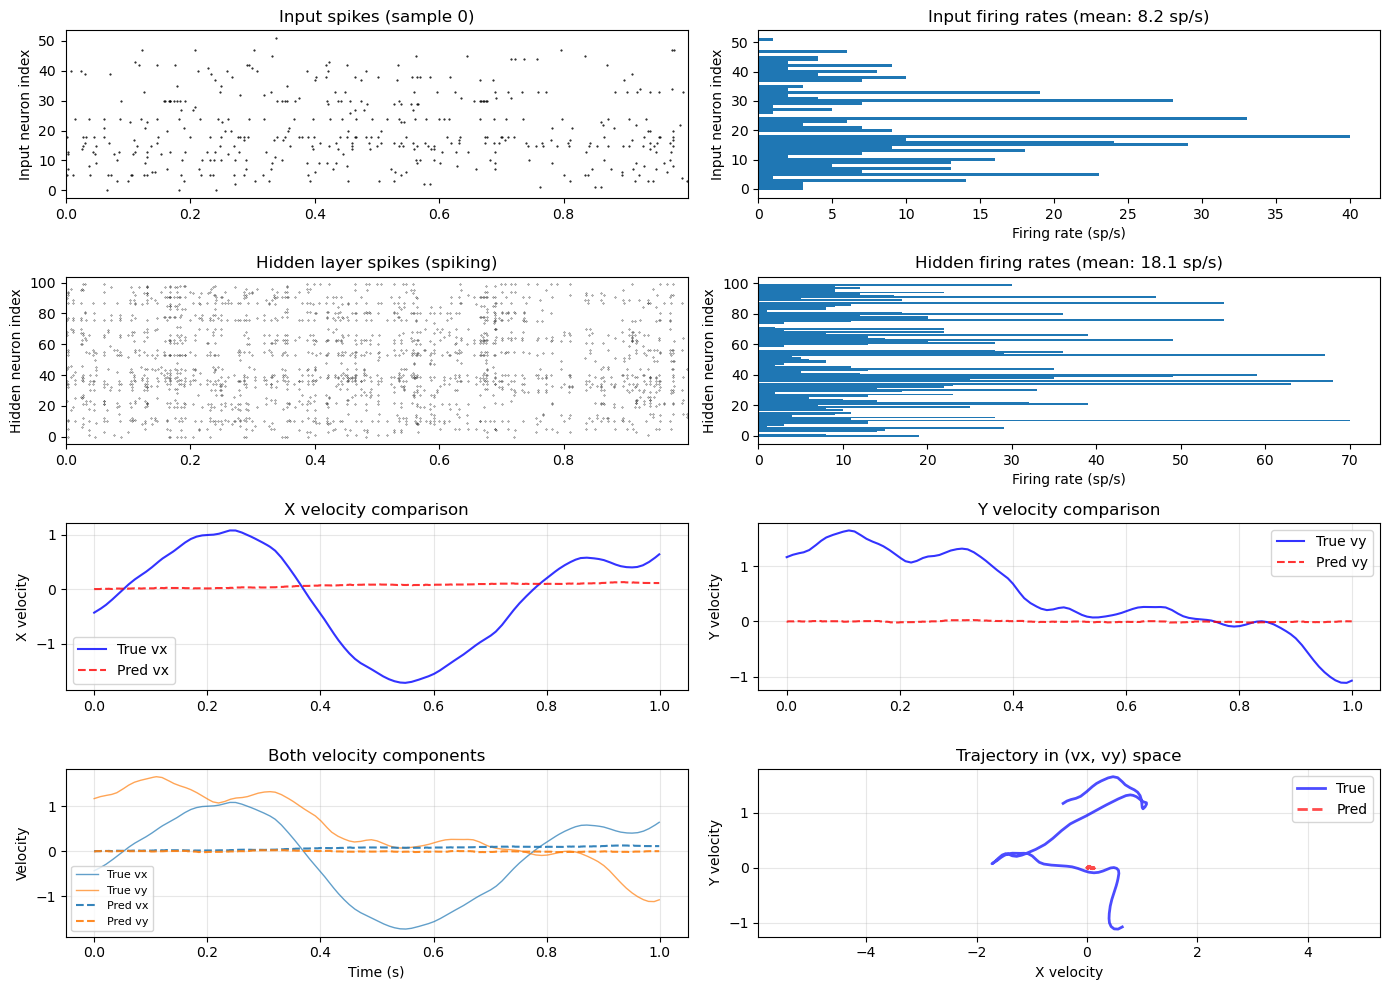

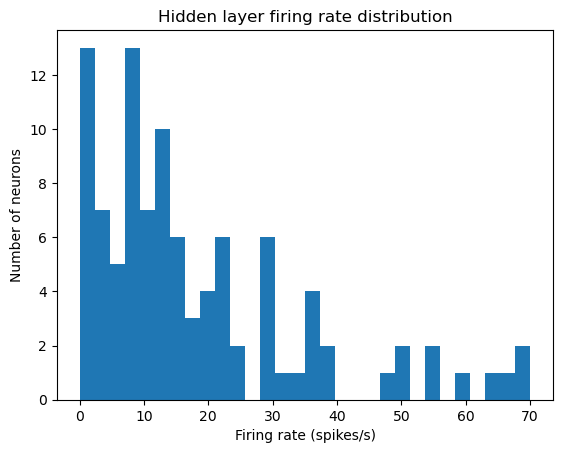

In [110]:
# Task 4: Evaluating fit to data

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


print("TASK 4: EVALUATING FIT TO DATA")

#Evaluation function
def evaluate_network(model, data_range, dt=1e-3, length=1.0, batch_size=64, max_num_batches=20):
    """
    Evaluate network on a dataset and compute mean loss.
    
    Parameters:
    model : nn.Module
        The network to evaluate
    data_range : list of tuples
        List of (start_time, end_time) segments to use
    dt : float
        Simulation time step
    length : float
        Length of each batch in seconds
    batch_size : int
        Batch size
    max_num_batches : int
        Maximum number of batches to evaluate
    
    Returns:
    mean_loss : float
        Mean squared error over the dataset
    null_loss : float
        Loss if we just output zeros (baseline)
    """
    criterion = nn.MSELoss()
    device = next(model.parameters()).device
    
    total_loss = 0.0
    total_null_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for x_batch, y_batch in batched_data(data_range, dt=dt, length=length, 
                                              batch_size=batch_size, 
                                              max_num_batches=max_num_batches):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            
            # Compute null loss
            y_null = torch.zeros_like(y_batch)
            null_loss = criterion(y_null, y_batch)
            total_null_loss += null_loss.item()
            
            num_batches += 1
    
    mean_loss = total_loss / num_batches
    null_loss = total_null_loss / num_batches
    
    return mean_loss, null_loss



#Plotting function with hidden layer
def plot_network_internals_with_hidden(model, x_batch, y_batch, batch_idx=0, dt=1e-3):
    """
    Plot internal network states including hidden layer.
    
    Required are input spikes, hidden layer spikes, output velocities,
    and firing rate histograms for spiking layers.
    """
    with torch.no_grad():
        # Forward pass through hidden layer
        hidden_output = model.hidden_layer(x_batch)
        # Forward pass through full model
        y_pred = model(x_batch)
    
    # Convert to numpy
    x = x_batch[batch_idx].cpu().numpy()
    hidden = hidden_output[batch_idx].cpu().numpy()
    y_true = y_batch[batch_idx].cpu().numpy()
    y_pred = y_pred[batch_idx].cpu().numpy()
    
    time = np.arange(x.shape[1]) * dt
    
    # Create figure with 4 rows
    fig = plt.figure(figsize=(14, 10))
    

    #Input layer
    #Input spikes (raster) plot
    ax1 = plt.subplot(4, 2, 1)
    for neuron_idx in range(x.shape[0]):
        spike_times = time[x[neuron_idx] > 0.5]
        if len(spike_times) > 0:
            plt.plot(spike_times, np.ones_like(spike_times) * neuron_idx, 
                    'k.', markersize=1)
    plt.ylabel('Input neuron index')
    plt.title(f'Input spikes (sample {batch_idx})')
    plt.xlim([0, time[-1]])
    
    #Input firing rates plot
    ax2 = plt.subplot(4, 2, 2)
    input_firing_rates = x.sum(axis=1) / time[-1]
    plt.barh(range(len(input_firing_rates)), input_firing_rates, height=1)
    plt.xlabel('Firing rate (sp/s)')
    plt.ylabel('Input neuron index')
    plt.title(f'Input firing rates (mean: {input_firing_rates.mean():.1f} sp/s)')
    

    #Hidden layer
    #Hidden layer spikes (raster) plot
    ax3 = plt.subplot(4, 2, 3)
    for neuron_idx in range(hidden.shape[0]):
        spike_times = time[hidden[neuron_idx] > 0.5]
        if len(spike_times) > 0:
            plt.plot(spike_times, np.ones_like(spike_times) * neuron_idx, 
                    'k.', markersize=0.5)
    plt.ylabel('Hidden neuron index')
    plt.title('Hidden layer spikes (spiking)')
    plt.xlim([0, time[-1]])
    
    # Hidden firing rates plot
    ax4 = plt.subplot(4, 2, 4)
    hidden_firing_rates = hidden.sum(axis=1) / time[-1]
    plt.barh(range(len(hidden_firing_rates)), hidden_firing_rates, height=1)
    plt.xlabel('Firing rate (sp/s)')
    plt.ylabel('Hidden neuron index')
    plt.title(f'Hidden firing rates (mean: {hidden_firing_rates.mean():.1f} sp/s)')

    #Output layer
    #X velocity plot
    ax5 = plt.subplot(4, 2, 5)
    plt.plot(time, y_true[0], 'b-', linewidth=1.5, label='True vx', alpha=0.8)
    plt.plot(time, y_pred[0], 'r--', linewidth=1.5, label='Pred vx', alpha=0.8)
    plt.ylabel('X velocity')
    plt.legend(loc='best')
    plt.title('X velocity comparison')
    plt.grid(True, alpha=0.3)
    
    #Y velocity plot
    ax6 = plt.subplot(4, 2, 6)
    plt.plot(time, y_true[1], 'b-', linewidth=1.5, label='True vy', alpha=0.8)
    plt.plot(time, y_pred[1], 'r--', linewidth=1.5, label='Pred vy', alpha=0.8)
    plt.ylabel('Y velocity')
    plt.legend(loc='best')
    plt.title('Y velocity comparison')
    plt.grid(True, alpha=0.3)
    

    #Combined views
    # Plot of both velocity components
    ax7 = plt.subplot(4, 2, 7)
    plt.plot(time, y_true[0], 'C0-', linewidth=1, label='True vx', alpha=0.7)
    plt.plot(time, y_true[1], 'C1-', linewidth=1, label='True vy', alpha=0.7)
    plt.plot(time, y_pred[0], 'C0--', linewidth=1.5, label='Pred vx', alpha=0.9)
    plt.plot(time, y_pred[1], 'C1--', linewidth=1.5, label='Pred vy', alpha=0.9)
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity')
    plt.legend(loc='best', fontsize=8)
    plt.title('Both velocity components')
    plt.grid(True, alpha=0.3)
    
    #2D trajectory plot
    ax8 = plt.subplot(4, 2, 8)
    plt.plot(y_true[0], y_true[1], 'b-', linewidth=2, label='True', alpha=0.7)
    plt.plot(y_pred[0], y_pred[1], 'r--', linewidth=2, label='Pred', alpha=0.7)
    plt.xlabel('X velocity')
    plt.ylabel('Y velocity')
    plt.legend(loc='best')
    plt.title('Trajectory in (vx, vy) space')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistics
    print(f"\nStatistics for batch {batch_idx}")
    print(f"Input layer:")
    print(f"  Mean firing rate: {input_firing_rates.mean():.1f} sp/s")
    print(f"  Active neurons: {(input_firing_rates > 0).sum()}/{len(input_firing_rates)}")
    
    print(f"\nHidden layer:")
    print(f"  Mean firing rate: {hidden_firing_rates.mean():.1f} sp/s")
    print(f"  Std firing rate: {hidden_firing_rates.std():.1f} sp/s")
    print(f"  Min/Max firing rate: {hidden_firing_rates.min():.1f} / {hidden_firing_rates.max():.1f} sp/s")
    print(f"  Active neurons: {(hidden_firing_rates > 0).sum()}/{len(hidden_firing_rates)}")
    print(f"  Target range: 20-100 sp/s" if 20 <= hidden_firing_rates.mean() <= 100 else "  Outside target range!")
    
    print(f"\nOutput layer:")
    print(f"  Predicted range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    print(f"  Target range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    
    return fig



# Enhanced SNNLayer with weight scale control
class SNNLayer(nn.Module):
    """Enhanced SNNLayer with better weight initialisation control."""
    
    def __init__(self, n_in, n_out, dt=1e-3, spiking=True, 
                 tau_min=20e-3, tau_max=100e-3, w_scale=1.0):
        super(SNNLayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.dt = dt
        self.spiking = spiking
        
        # Trainable weights with adjustable scale
        if spiking:
            # Spiking layers need stronger weights to reach threshold
            self.w = nn.Parameter(torch.randn(n_in, n_out) * w_scale / np.sqrt(n_in))
        else:
            # Non-spiking layers can use smaller weights
            self.w = nn.Parameter(torch.randn(n_in, n_out) * w_scale / np.sqrt(n_in))
        
        # Trainable time constants
        tau_init = torch.rand(n_out) * (tau_max - tau_min) + tau_min
        self.log_tau = nn.Parameter(torch.log(tau_init))
        
    def get_tau(self):
        return torch.exp(self.log_tau)
    
    def forward(self, x):
        batch_size, n_in, num_time_points = x.shape
        assert n_in == self.n_in
        
        tau = self.get_tau()
        alpha = torch.exp(-self.dt / tau)
        
        v = torch.zeros(batch_size, self.n_out, device=x.device, dtype=x.dtype)
        outputs = torch.zeros(batch_size, self.n_out, num_time_points, 
                            device=x.device, dtype=x.dtype)
        
        for t in range(num_time_points):
            x_t = x[:, :, t]
            I = torch.matmul(x_t, self.w)
            
            # Leaky integration with direct spike addition
            v = alpha * v + I
            
            if self.spiking:
                s = surrogate_heaviside(v - 1.0)
                outputs[:, :, t] = s
                v = v * (1 - s) #Reset v to 0
            else:
                outputs[:, :, t] = v
        
        return outputs

# Two-layer SNN
class TwoLayerSNN(nn.Module):
    """
    Two-layer SNN with optimised initialisation.
    - Hidden layer: 100 spiking LIF neurons
    - Output layer: 2 non-spiking LIF neurons
    """
    def __init__(self, n_in, n_hidden=100, n_out=2, dt=1e-3, 
                 hidden_w_scale=4.0, output_w_scale=0.01):
        super().__init__()
        
        # Hidden layer: spiking
        self.hidden_layer = SNNLayer(
            n_in=n_in,
            n_out=n_hidden,
            dt=dt,
            spiking=True,
            tau_min=20e-3,
            tau_max=100e-3,
            w_scale=hidden_w_scale
        )
        
        # Output layer: non-spiking
        self.output_layer = SNNLayer(
            n_in=n_hidden,
            n_out=n_out,
            dt=dt,
            spiking=False,
            tau_min=200e-3,
            tau_max=1000e-3,
            w_scale=output_w_scale
        )
    
    def forward(self, x):
        h = self.hidden_layer(x)
        y = self.output_layer(h)
        return y

#Initialise and evaluate network


print("\nInitialise two-layer network\n")

# Parameters
dt_sim = 1e-3
num_neurons = len(spike_times)
n_hidden = 100

# Create model with optimised initialisation
model = TwoLayerSNN(
    n_in=num_neurons, 
    n_hidden=n_hidden, 
    n_out=2, 
    dt=dt_sim, 
    hidden_w_scale=4.0,   # For good firing rates (20-100 sp/s)
    output_w_scale=0.01   # To control output range
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f"Model architecture:")
print(f"  Input neurons: {num_neurons}")
print(f"  Hidden neurons: {n_hidden} (spiking)")
print(f"  Output neurons: 2 (non-spiking)")
print(f"  Weight scales: hidden={4.0}, output={0.01}")
print(f"  Device: {device}\n")

# Evaluate untrained network
print("Evaluating untrained network")
train_loss, train_null_loss = evaluate_network(model, train_range, dt=dt_sim, 
                                                length=1.0, batch_size=32, 
                                                max_num_batches=10)
val_loss, val_null_loss = evaluate_network(model, val_range, dt=dt_sim, 
                                            length=1.0, batch_size=32, 
                                            max_num_batches=10)

print(f"\nUntrained network performance:")
print(f"  Train loss: {train_loss:.4f}")
print(f"  Train null loss: {train_null_loss:.4f}")
print(f"  Val loss: {val_loss:.4f}")
print(f"  Val null loss: {val_null_loss:.4f}")
print(f"\nGoal: After training, loss should be < {val_null_loss:.4f}")

# Plot network internals with hidden layer
x_sample, y_sample = next(batched_data(train_range, dt=dt_sim, length=1.0, batch_size=4))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

fig = plot_network_internals_with_hidden(model, x_sample, y_sample, 
                                         batch_idx=0, dt=dt_sim)

with torch.no_grad():
    hidden_output = model.hidden_layer(x_sample) # Reuse x_sample from above
hidden = hidden_output[0].cpu().numpy() # For batch_idx=0
time = np.arange(hidden.shape[1]) * dt_sim
hidden_firing_rates = hidden.sum(axis=1) / time[-1]

 
plt.figure()
plt.hist(hidden_firing_rates, bins=30)
plt.xlabel("Firing rate (spikes/s)")
plt.ylabel("Number of neurons")
plt.title("Hidden layer firing rate distribution")
plt.show()

## Task 5: Training

At last, we get to the stage of training our network to fit the data.

Start with a network consisting of a single non-spiking output layer (i.e. spikes connected directly via a weight matrix to two non-spiking LIF neurons as output).

1. ⚠️ Find a good initialisation for this network that gives outputs roughly in the right range.
2. ⚠️ Write code to train your network to minimise the mean squared error between the output of your network and the recorded velocities. You will need to select an optimisation algorithm, learning rate, etc.
3. ⚠️ Train your network, plotting the loss curves for the training and validation data during training, and print out the test loss at the end.
4. ⚠️ Plot the output of your model and compare to the data for 8 randomly sampled time windows of length 1.

Don't worry too much about performance at the moment. You should be able to do better than the null loss, but you don't need to do hugely better. I get a null loss of around 1.04 and a test loss of around 0.55, but it's OK if you don't get such good results, and you may get much better results because I didn't do any hyperparameter searching.

You may want to use the following code as a starting point (it worked well enough for me but you can probably do better). On my desktop with CPU only, this took about two minutes to train.

In [111]:
# # Training parameters
# lr = 0.001 # learning rate
# num_epochs = 10
# max_num_batches = 40
# length = 1
# batch_size = 32 # small batches worked better for me for some reason

# # Optimiser and loss function
# optimizer = torch.optim.Adam(..., lr=lr) # what should the first argument be?

# # Training
# loss_hist = []
# val_loss_hist = []
# with tqdm(total=num_epochs*max_num_batches) as pbar:
#   last_epoch_loss = val_loss = null_val_loss = None
#   for epoch in range(num_epochs):
#     local_loss = []
#     for x, y in batched_data(...):
#       # Run the network
#       y_out = net(x)
#       # Compute a loss
#       loss = mse(y_out, y)
#       local_loss.append(loss.item())
#       # Update gradients
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       # do something to ensure that taus remain positive, maybe set 1 ms as minimum value
#       pbar.update(1)
#       pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     last_epoch_loss = np.mean(local_loss)
#     val_loss, null_val_loss = evaluate_network(net, ...)
#     pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     loss_hist.append(last_epoch_loss)
#     val_loss_hist.append(val_loss)

# # Plot the loss function over time
# plt.semilogy(loss_hist, label='Testing loss')
# plt.semilogy(val_loss_hist, label='Validation loss')
# plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(loc='best')
# plt.tight_layout()

# testing_loss, null_testing_loss = evaluate_network(net, testing_range, length=length, batch_size=batch_size)
# print(f'{testing_loss=}, {null_testing_loss=}')

# # Plot trained output
# plt.figure(figsize=(16, 6))
# with torch.no_grad():
#   for x, y in batched_data(..., batch_size=8, max_num_batches=1):
#     for b in range(8):
#       plt.subplot(2, 4, b+1)
#       y_out = net(x)
#       plt.plot(y_out[b, 0, :], ':C0', label='x_out')
#       plt.plot(y_out[b, 1, :], ':C1', label='y_out')
#       plt.plot(y[b, 0, :], '--C0', label='x')
#       plt.plot(y[b, 1, :], '--C1', label='y')
#       # Plot a smoothed version as well
#       plt.plot(savgol_filter(y_out[b, 0, :], 151, 3), '-C0', label='x_out (smooth)')
#       plt.plot(savgol_filter(y_out[b, 1, :], 151, 3), '-C1', label='y_out (smooth)')
#       plt.ylim(-5, 5)
# plt.tight_layout();


Single non-spiking layer initialisation

Single-layer model:
  Input: 52 neurons (spike trains)
  Output: 2 neurons (vx, vy) - non-spiking
  Device: cpu

Initialisation check:
  Output range: [-1.53, 0.45]
  Target range: [-3.61, 1.72]
  Initialisation looks reasonable

Training parameters:
  Learning rate: 0.001
  Epochs: 10
  Batches per epoch: 40
  Batch size: 32
  Batch length: 1.0s


  0%|          | 0/400 [00:00<?, ?it/s]

Final results:
  Training loss: 0.6583
  Validation loss: 0.6602
  Test loss: 0.5941
  Null test loss: 0.9478
  Improvement: 37.3%
Success! Test loss < null loss


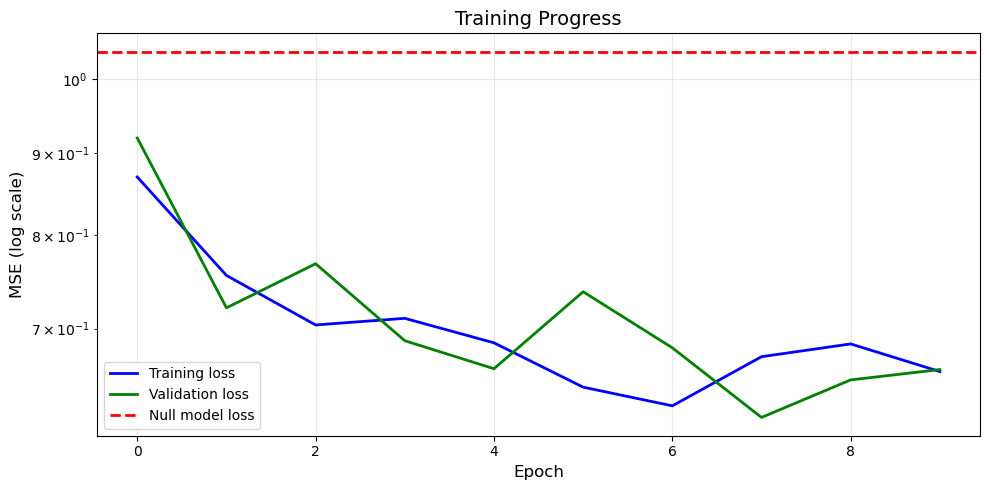


Plotting trained model outputs



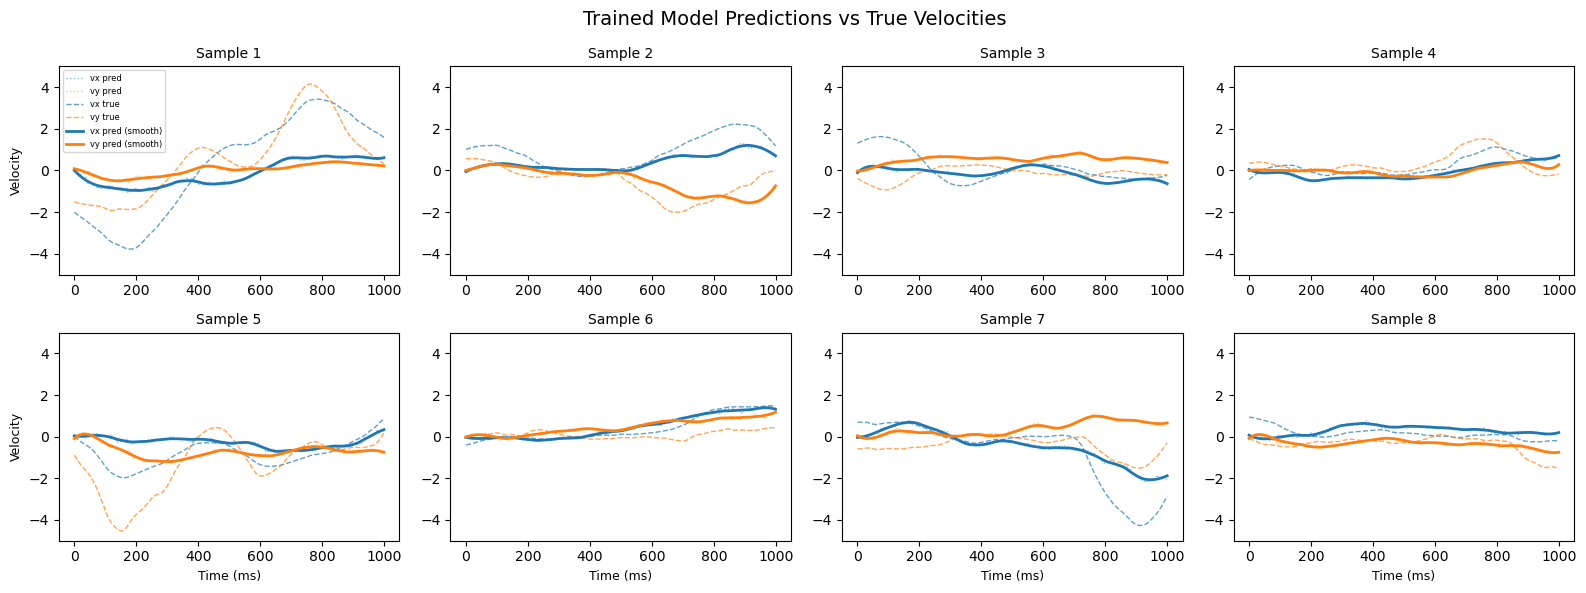

In [112]:

# Task 5: Training
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm

#Single non-spiking layer

print("\nSingle non-spiking layer initialisation\n")

# Create simple single-layer model
dt_sim = 1e-3
num_neurons = len(spike_times)

# Simple single-layer decoder
single_layer_model = SNNLayer(
    n_in=num_neurons,
    n_out=2,
    dt=dt_sim,
    spiking=False,
    tau_min=200e-3,  # 200ms for non-spiking
    tau_max=1000e-3,  # 1000ms for non-spiking
    w_scale=0.1       # Small weights for reasonable output range
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
single_layer_model = single_layer_model.to(device)

print(f"Single-layer model:")
print(f"  Input: {num_neurons} neurons (spike trains)")
print(f"  Output: 2 neurons (vx, vy) - non-spiking")
print(f"  Device: {device}")

# Check initialisation
x_sample, y_sample = next(batched_data(train_range, dt=dt_sim, length=1.0, batch_size=4))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

with torch.no_grad():
    y_pred = single_layer_model(x_sample)

print(f"\nInitialisation check:")
print(f"  Output range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
print(f"  Target range: [{y_sample.min():.2f}, {y_sample.max():.2f}]")
print(f"  Initialisation looks reasonable")



#Training code
# Training parameters
lr = 0.001
num_epochs = 10
max_num_batches = 40
length = 1.0
batch_size = 32

# Loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.Adam(single_layer_model.parameters(), lr=lr)

print(f"\nTraining parameters:")
print(f"  Learning rate: {lr}")
print(f"  Epochs: {num_epochs}")
print(f"  Batches per epoch: {max_num_batches}")
print(f"  Batch size: {batch_size}")
print(f"  Batch length: {length}s")

# Training loop
loss_hist = []
val_loss_hist = []

with tqdm(total=num_epochs*max_num_batches) as pbar:
    last_epoch_loss = val_loss = null_val_loss = None
    
    for epoch in range(num_epochs):
        local_loss = []
        
        for x_batch, y_batch in batched_data(train_range, dt=dt_sim, 
                                              length=length, batch_size=batch_size,
                                              max_num_batches=max_num_batches):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_out = single_layer_model(x_batch)
            
            # Compute loss
            loss = criterion(y_out, y_batch)
            local_loss.append(loss.item())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Ensure time constants remain positive (tau >= 1ms)
            with torch.no_grad():
                single_layer_model.log_tau.clamp_(min=np.log(1e-3))
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix(
                epoch=epoch,
                last_epoch_loss=last_epoch_loss,
                loss=loss.item(),
                val_loss=val_loss,
                null_val_loss=null_val_loss
            )
        
        # Evaluate on validation set
        last_epoch_loss = np.mean(local_loss)
        val_loss, null_val_loss = evaluate_network(
            single_layer_model, val_range, 
            dt=dt_sim, length=length, batch_size=batch_size,
            max_num_batches=10
        )
        
        # Update progress bar
        pbar.set_postfix(
            epoch=epoch,
            last_epoch_loss=last_epoch_loss,
            loss=loss.item(),
            val_loss=val_loss,
            null_val_loss=null_val_loss
        )
        
        # Store losses
        loss_hist.append(last_epoch_loss)
        val_loss_hist.append(val_loss)

# Evaluate on test set
test_loss, null_test_loss = evaluate_network(
    single_layer_model, test_range,
    dt=dt_sim, length=length, batch_size=batch_size,
    max_num_batches=10
)

print(f"Final results:")
print(f"  Training loss: {loss_hist[-1]:.4f}")
print(f"  Validation loss: {val_loss_hist[-1]:.4f}")
print(f"  Test loss: {test_loss:.4f}")
print(f"  Null test loss: {null_test_loss:.4f}")
print(f"  Improvement: {((null_test_loss - test_loss) / null_test_loss * 100):.1f}%")

if test_loss < null_test_loss:
    print(f"Success! Test loss < null loss")
else:
    print(f"Test loss still above null loss (may need more training)")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.semilogy(loss_hist, 'b-', label='Training loss', linewidth=2)
plt.semilogy(val_loss_hist, 'g-', label='Validation loss', linewidth=2)
plt.axhline(null_val_loss, ls='--', c='r', linewidth=2, label='Null model loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE (log scale)', fontsize=12)
plt.title('Training Progress', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#Plot trained outputs
print("\nPlotting trained model outputs\n")

# Get 8 random samples
plt.figure(figsize=(16, 6))

with torch.no_grad():
    for x_batch, y_batch in batched_data(test_range, dt=dt_sim,
                                         length=length, batch_size=8,
                                         max_num_batches=1):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Get predictions
        y_out = single_layer_model(x_batch)
        
        # Convert to numpy
        y_out_np = y_out.cpu().numpy()
        y_batch_np = y_batch.cpu().numpy()
        
        # Plot each sample
        for b in range(8):
            plt.subplot(2, 4, b+1)
            
            # Plot raw predictions
            plt.plot(y_out_np[b, 0, :], ':C0', label='vx pred', alpha=0.5, linewidth=1)
            plt.plot(y_out_np[b, 1, :], ':C1', label='vy pred', alpha=0.5, linewidth=1)
            
            # Plot targets
            plt.plot(y_batch_np[b, 0, :], '--C0', label='vx true', alpha=0.7, linewidth=1)
            plt.plot(y_batch_np[b, 1, :], '--C1', label='vy true', alpha=0.7, linewidth=1)
            
            # Plot smoothed predictions (Savitzky-Golay filter)
            plt.plot(savgol_filter(y_out_np[b, 0, :], 151, 3), '-C0', 
                    label='vx pred (smooth)', linewidth=2)
            plt.plot(savgol_filter(y_out_np[b, 1, :], 151, 3), '-C1', 
                    label='vy pred (smooth)', linewidth=2)
            
            plt.ylim(-5, 5)
            plt.title(f'Sample {b+1}', fontsize=10)
            
            if b == 0:
                plt.legend(loc='best', fontsize=6)
            
            if b >= 4:
                plt.xlabel('Time (ms)', fontsize=9)
            if b % 4 == 0:
                plt.ylabel('Velocity', fontsize=9)

plt.suptitle('Trained Model Predictions vs True Velocities', fontsize=14)
plt.tight_layout()
plt.show()

## Task 6: Longer length decoding

Your code above probably doesn't look great when plotted. That's partly because the outputs start at 0 but the data doesn't necessarily have to, so it takes a while for them to get in sync, and partly because on some intervals it will just do badly. To fix this, and to extend the fit to a longer range of data, in this task we only use the final timestep of each segment and compare to the data. Take a 15 second segment of testing data, and sample every 0.2 seconds to get 75 data points. For each data point, take a 1 second segment of time before this data point (these will be overlapping), run your simulation for that one second, and use the final time point of the simulated output as your prediction. Plot this compared to the real data for 8 different segments of 15 seconds.

This should look like a reasonable fit to the data. Congratulations, you have used raw spiking output of neurons recorded from a monkey's brain to predict what it was doing on a computer screen it was interacting with. That's a brain machine interface right here.

1. ⚠️ Implement the decoding plot and run it on your trained network.

You can use the template below to get you started.

Your results might look something like this:

![Fits](fits.png)

In [113]:
# def decoding_plot(net, dt_decoding=0.2, decoding_start=1000, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2)):
#     w_intervals = np.arange(decoding_start+length, decoding_start+length+decoding_length, dt_decoding)
#     batch_size_single = len(w_intervals)-1
#     num_time_points = int(np.round(length/dt))
#     nfx, nfy = figdims
#     nf = nfx*nfy
#     batch_size = nf*batch_size_single
#     nrows = nfy*2
#     ncols = nfx
#     with torch.no_grad():
#         x = torch.zeros((batch_size, num_neurons, num_time_points))
#         y = torch.zeros((batch_size, 2, num_time_points))
#         T = []
#         for b in range(batch_size):
#            w_start = decoding_start+dt_decoding*b
#            w_end = w_start+length
#            T.append(w_end)
#            # ... (copy data to x, y)
#         T = np.array(T)
#         y_out = ...
#         mean_mse = mse(y, y_out)
#         plt.figure(figsize=(ncols*3, nrows*2))
#         for nf_i in range(nf):
#             sp_x = nf_i % nfx
#             sp_y = nf_i // nfx
#             for i in range(2):
#                 plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+i*ncols)
#                 # ...
#                 plt.ylim(-4, 4)
#                 if sp_x==0:
#                     plt.ylabel('Velocity')
#                 if 2*sp_y+i==nrows-1:
#                     plt.xlabel('Time (s)')
#                 if nf_i==0:
#                     plt.legend(loc='best')
#         plt.suptitle(f'{net.fname}: {mean_mse=:.3f}')
#         plt.tight_layout()

# decoding_plot(models['single_layer.pt'])

TASK 6: LONGER LENGTH DECODING

Mean MSE (final timestep): 0.6255


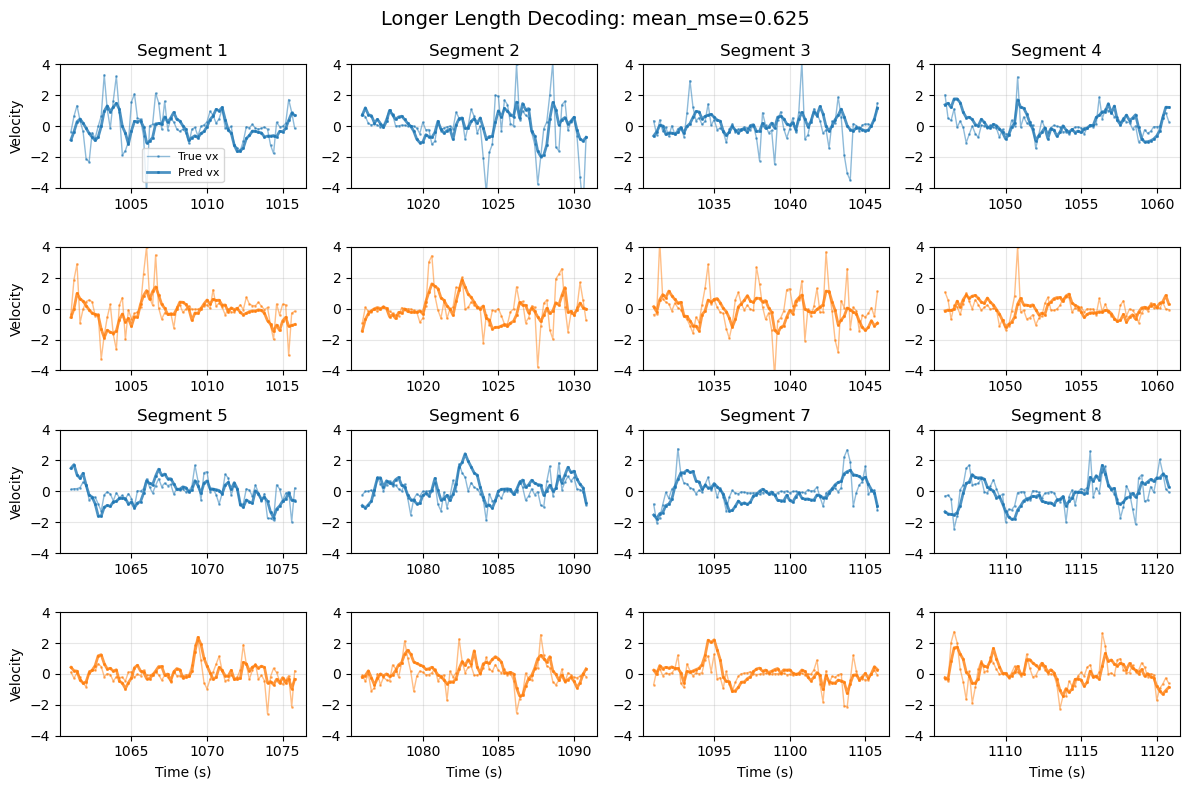


Results:
  Generated 8 segments of 15-second predictions
  Each segment uses 1s sliding windows sampled every 0.2s
  Final timestep used for stable predictions
  MSE on final timesteps: 0.6255

Interpretation:
  This approach gives much smoother predictions than using all
  timesteps, as it avoids the transient startup period and only
  uses the stabilised output at the end of each 1-second window.


In [114]:
#TASK 6: LONGER LENGTH DECODING
def decoding_plot(net, dt_decoding=0.2, decoding_start=1000, decoding_length=15, 
                  length=1, dt=1e-3, figdims=(4, 2)):
    """
    Create decoding plots using final timestep predictions.
    Uses sliding 1-second windows sampled every dt_decoding seconds.
    """
    # Calculate sampling intervals
    w_intervals = np.arange(decoding_start + length, 
                           decoding_start + length + decoding_length, 
                           dt_decoding)
    
    batch_size_single = len(w_intervals)
    num_time_points = int(np.round(length / dt))
    nfx, nfy = figdims
    nf = nfx * nfy
    batch_size = nf * batch_size_single
    nrows = nfy * 2
    ncols = nfx
    
    with torch.no_grad():
        # Preallocate tensors
        x = torch.zeros((batch_size, num_neurons, num_time_points))
        y = torch.zeros((batch_size, 2, num_time_points))
        T = []
        
        # Build all input windows
        for b in range(batch_size):
            segment_idx = b // batch_size_single
            sample_idx = b % batch_size_single
            
            # Calculate time window
            segment_start = decoding_start + segment_idx * decoding_length
            w_end = segment_start + length + sample_idx * dt_decoding
            w_start = w_end - length
            T.append(w_end)
            
            # Fill spike data
            for neuron_idx, st in enumerate(spike_times):
                spikes_in_window = st[(st >= w_start) & (st < w_end)]
                if len(spikes_in_window) > 0:
                    spike_indices = ((spikes_in_window - w_start) / dt).astype(int)
                    spike_indices = spike_indices[spike_indices < num_time_points]
                    x[b, neuron_idx, spike_indices] = 1.0
            
            # Fill velocity data
            time_grid = np.arange(num_time_points) * dt
            batch_time_points = w_start + time_grid
            vel_mask = (vel_times >= w_start - 0.1) & (vel_times <= w_end + 0.1)
            vel_times_local = vel_times[vel_mask]
            vel_local = vel[vel_mask, :]
            
            if len(vel_times_local) > 1:
                for dim in range(2):
                    y[b, dim, :] = torch.from_numpy(
                        np.interp(batch_time_points, vel_times_local, vel_local[:, dim])
                    ).float()
        
        T = np.array(T)
        
        # Run model and extract final timesteps
        x = x.to(device)
        y_out = net(x)
        y_pred_final = y_out[:, :, -1].cpu().numpy()
        y_true_final = y[:, :, -1].numpy()
        
        # Calculate MSE using numpy
        mean_mse = np.mean((y_pred_final - y_true_final) ** 2)
        
        print(f"\nMean MSE (final timestep): {mean_mse:.4f}")
        
        # Create plots
        plt.figure(figsize=(ncols * 3, nrows * 2))
        
        for nf_i in range(nf):
            sp_x = nf_i % nfx
            sp_y = nf_i // nfx
            
            start_idx = nf_i * batch_size_single
            end_idx = (nf_i + 1) * batch_size_single
            
            T_segment = T[start_idx:end_idx]
            y_pred_segment = y_pred_final[start_idx:end_idx, :]
            y_true_segment = y_true_final[start_idx:end_idx, :]
            
            for i in range(2):
                plt.subplot(nrows, ncols, sp_x + 1 + 2*ncols*sp_y + i*ncols)
                plt.plot(T_segment, y_true_segment[:, i], 'o-', 
                        color='C0' if i == 0 else 'C1', alpha=0.5, linewidth=1, 
                        markersize=1, label=f'True v{"x" if i == 0 else "y"}')
                plt.plot(T_segment, y_pred_segment[:, i], 's-', 
                        color='C0' if i == 0 else 'C1', alpha=0.8, linewidth=2, 
                        markersize=1, label=f'Pred v{"x" if i == 0 else "y"}')
                plt.ylim(-4, 4)
                plt.grid(True, alpha=0.3)
                if sp_x == 0:
                    plt.ylabel('Velocity')
                if 2*sp_y + i == nrows - 1:
                    plt.xlabel('Time (s)')
                if nf_i == 0 and i == 0:
                    plt.legend(loc='best', fontsize=8)
                if i == 0:
                    plt.title(f'Segment {nf_i+1}')
        
        # Use net.fname if it exists, otherwise just show MSE
        if hasattr(net, 'fname'):
            plt.suptitle(f'{net.fname}: mean_mse={mean_mse:.3f}', fontsize=14)
        else:
            plt.suptitle(f'Longer Length Decoding: mean_mse={mean_mse:.3f}', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        return mean_mse


# Run the decoding plot
print("TASK 6: LONGER LENGTH DECODING")

decoding_mse = decoding_plot(single_layer_model)

print(f"\nResults:")
print(f"  Generated 8 segments of 15-second predictions")
print(f"  Each segment uses 1s sliding windows sampled every 0.2s")
print(f"  Final timestep used for stable predictions")
print(f"  MSE on final timesteps: {decoding_mse:.4f}")
print(f"\nInterpretation:")
print(f"  This approach gives much smoother predictions than using all")
print(f"  timesteps, as it avoids the transient startup period and only")
print(f"  uses the stabilised output at the end of each 1-second window.")

## Task 7: Comparing spiking and non-spiking

1. ⚠️ Now try training your network with at least one spiking hidden layer. Compare your results to the non-spiking version. Note that training times with a spiking hidden layer are likely to be much longer. My training time went up from 2 minutes to 30 minutes (with CPU only).
2. ⚠️ Plot the trained distribution of weights and time constants for both models.

You might find it interesting to compare the distribution of time constants you find for the spiking hidden layer with the results in our paper [Perez et al. 2021](https://neural-reckoning.org/pub_heterogeneity.html). Note: this is not required for credit, only for your interest.

Well done - you have made it to the end!

TASK 7: COMPARING SPIKING AND NON-SPIKING NETWORKS

Training two-layer network

Two-layer model architecture:
  Input: 52 neurons (spike trains)
  Hidden: 100 neurons (spiking LIF)
  Output: 2 neurons (non-spiking LIF)
  Device: cpu

Initial hidden layer firing rates:
  Mean: 20.8 sp/s
  Range: 0.0 - 84.1 sp/s
  Active neurons: 83/100

Training parameters:
  Learning rate: 0.001
  Epochs: 10
  Batches per epoch: 40
  Batch size: 32


  0%|          | 0/400 [00:00<?, ?it/s]

TRAINING RESULTS COMPARISON

Single-layer (non-spiking):
  Test loss: 0.6093
  Null loss: 0.9320
  Improvement: 34.6%

Two-layer (with spiking hidden):
  Test loss: 0.6057
  Null loss: 0.9992
  Improvement: 39.4%

Comparison:
Two-layer is better by 0.6%

Comparing training curves



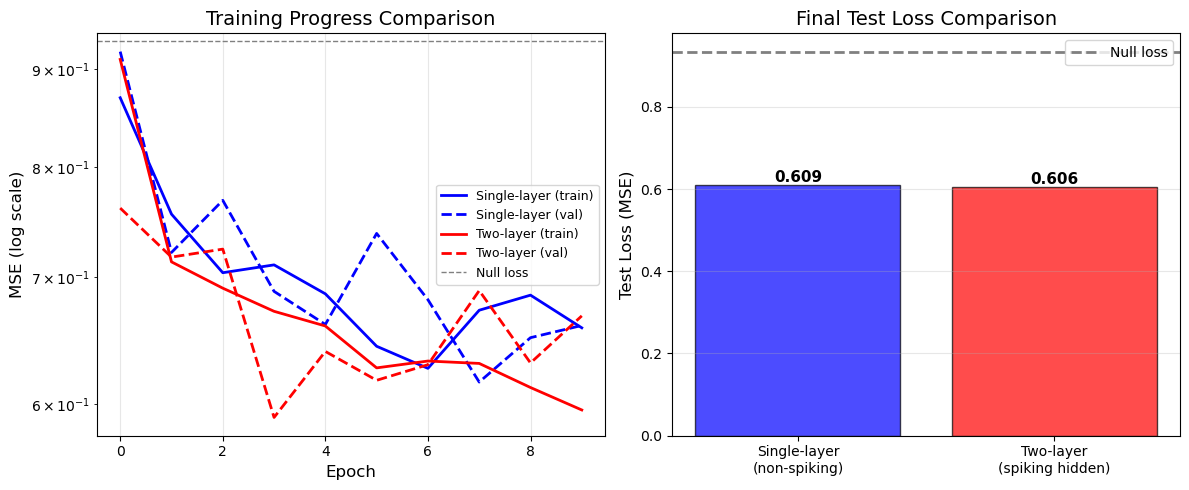

Single-layer model:

Mean MSE (final timestep): 0.6255


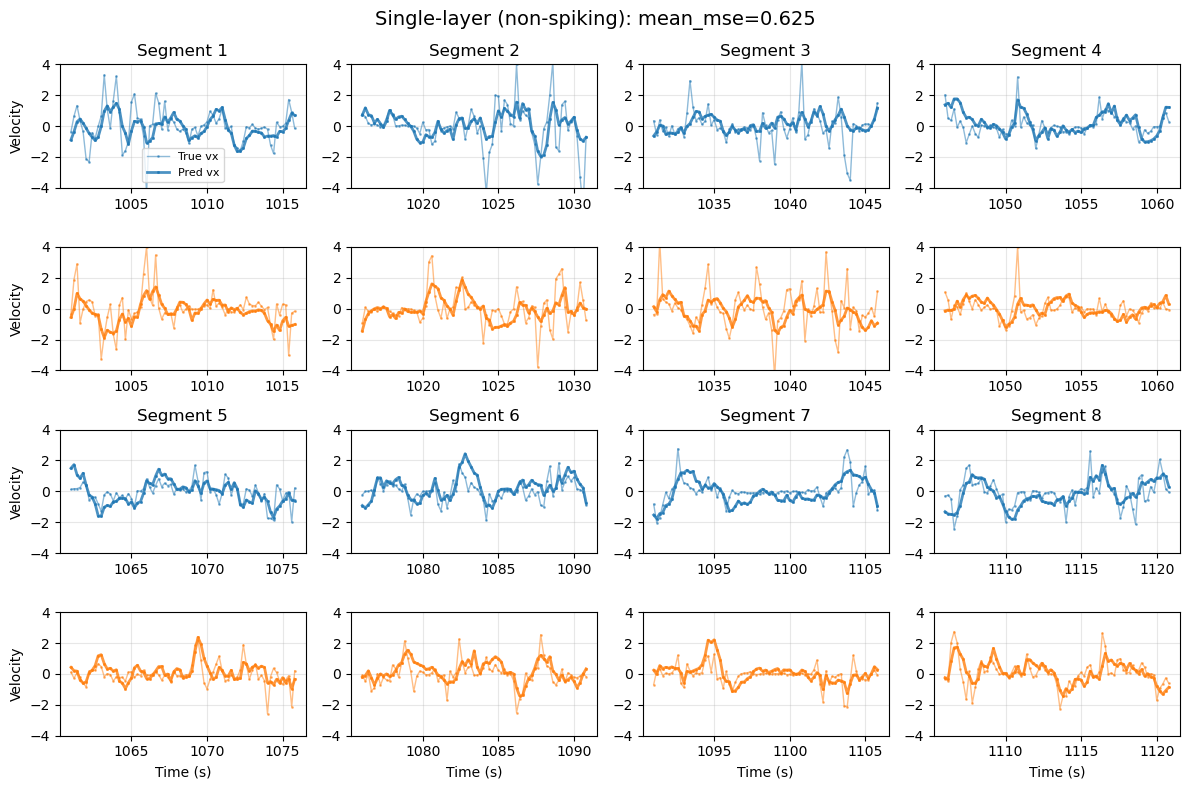


Two-layer model:

Mean MSE (final timestep): 0.5620


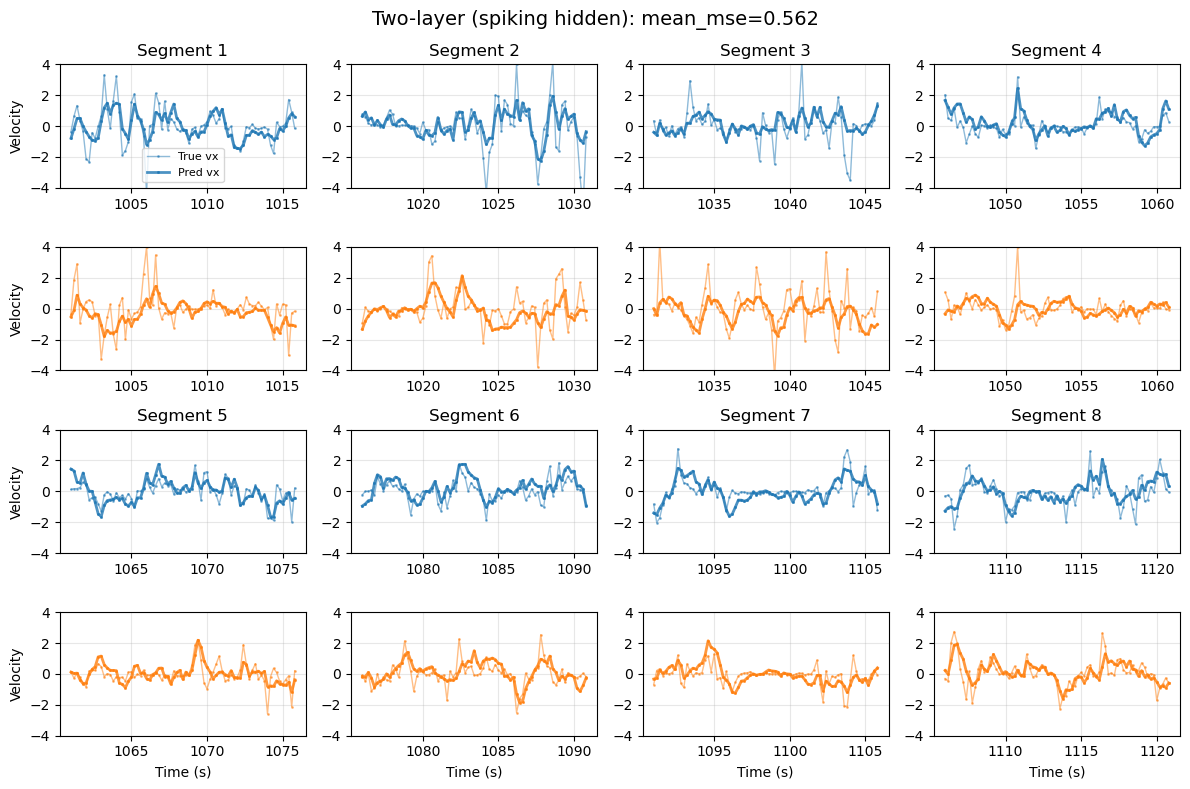


Decoding MSE comparison:
  Single-layer: 0.6255
  Two-layer:    0.5620

Analysing learned parameters



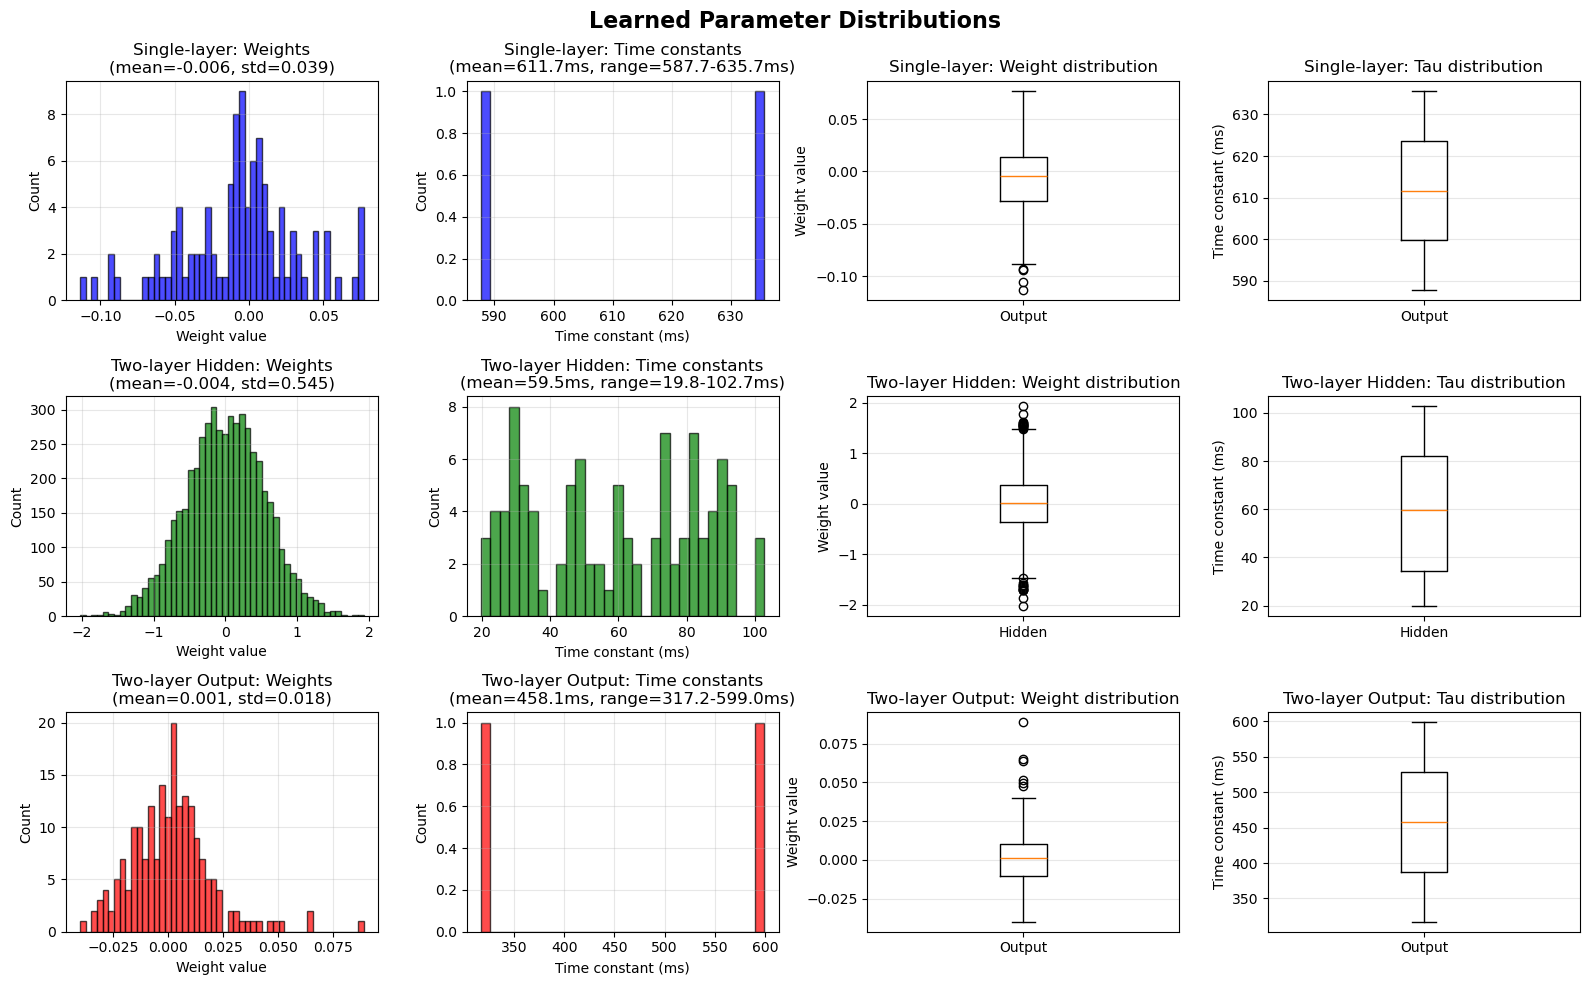


FINAL RESULTS:

1. MODEL ARCHITECTURES:
   Single-layer: 52 → 2 (non-spiking)
   Two-layer:    52 → 100 (spiking) → 2 (non-spiking)

2. TEST PERFORMANCE:
   Single-layer test loss: 0.6093
   Two-layer test loss:    0.6057
   Two-layer performs better!

3. DECODING PERFORMANCE (15-second segments):
   Single-layer MSE: 0.6255
   Two-layer MSE:    0.5620

4. LEARNED PARAMETERS:
   Single-layer:
     - Weights: mean=-0.006, std=0.039
     - Time constants: 587.7-635.7ms (mean=611.7ms)

   Two-layer Hidden:
     - Weights: mean=-0.004, std=0.545
     - Time constants: 19.8-102.7ms (mean=59.5ms)

   Two-layer Output:
     - Weights: mean=0.001, std=0.018
     - Time constants: 317.2-599.0ms (mean=458.1ms)


In [115]:
# TASK 7: COMPARING SPIKING AND NON-SPIKING
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("TASK 7: COMPARING SPIKING AND NON-SPIKING NETWORKS")

# Train two-layer network with spiking hidden layer
print("\nTraining two-layer network\n")

# Create two-layer model
dt_sim = 1e-3
num_neurons = len(spike_times)
n_hidden = 100

two_layer_model = TwoLayerSNN(
    n_in=num_neurons,
    n_hidden=n_hidden,
    n_out=2,
    dt=dt_sim,
    hidden_w_scale=4.0,
    output_w_scale=0.01
)

two_layer_model = two_layer_model.to(device)

print(f"Two-layer model architecture:")
print(f"  Input: {num_neurons} neurons (spike trains)")
print(f"  Hidden: {n_hidden} neurons (spiking LIF)")
print(f"  Output: 2 neurons (non-spiking LIF)")
print(f"  Device: {device}")

# Check initialization
x_sample, y_sample = next(batched_data(train_range, dt=dt_sim, length=1.0, batch_size=4))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

with torch.no_grad():
    hidden_output = two_layer_model.hidden_layer(x_sample)
    y_pred = two_layer_model(x_sample)

hidden = hidden_output[0].cpu().numpy()
time = np.arange(hidden.shape[1]) * dt_sim
hidden_firing_rates = hidden.sum(axis=1) / time[-1]

print(f"\nInitial hidden layer firing rates:")
print(f"  Mean: {hidden_firing_rates.mean():.1f} sp/s")
print(f"  Range: {hidden_firing_rates.min():.1f} - {hidden_firing_rates.max():.1f} sp/s")
print(f"  Active neurons: {(hidden_firing_rates > 0).sum()}/{n_hidden}")

# Training parameters
lr = 0.001
num_epochs = 10
max_num_batches = 40
length = 1.0
batch_size = 32

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(two_layer_model.parameters(), lr=lr)

print(f"\nTraining parameters:")
print(f"  Learning rate: {lr}")
print(f"  Epochs: {num_epochs}")
print(f"  Batches per epoch: {max_num_batches}")
print(f"  Batch size: {batch_size}")

# Training loop
loss_hist_two_layer = []
val_loss_hist_two_layer = []

with tqdm(total=num_epochs*max_num_batches) as pbar:
    last_epoch_loss = val_loss = null_val_loss = None
    
    for epoch in range(num_epochs):
        local_loss = []
        
        for x_batch, y_batch in batched_data(train_range, dt=dt_sim,
                                              length=length, batch_size=batch_size,
                                              max_num_batches=max_num_batches):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_out = two_layer_model(x_batch)
            
            # Compute loss
            loss = criterion(y_out, y_batch)
            local_loss.append(loss.item())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Ensure time constants remain positive (tau >= 1ms)
            with torch.no_grad():
                two_layer_model.hidden_layer.log_tau.clamp_(min=np.log(1e-3))
                two_layer_model.output_layer.log_tau.clamp_(min=np.log(1e-3))
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix(
                epoch=epoch,
                last_epoch_loss=last_epoch_loss,
                loss=loss.item(),
                val_loss=val_loss,
                null_val_loss=null_val_loss
            )
        
        # Evaluate on validation set
        last_epoch_loss = np.mean(local_loss)
        val_loss, null_val_loss = evaluate_network(
            two_layer_model, val_range,
            dt=dt_sim, length=length, batch_size=batch_size,
            max_num_batches=10
        )
        
        pbar.set_postfix(
            epoch=epoch,
            last_epoch_loss=last_epoch_loss,
            loss=loss.item(),
            val_loss=val_loss,
            null_val_loss=null_val_loss
        )
        
        loss_hist_two_layer.append(last_epoch_loss)
        val_loss_hist_two_layer.append(val_loss)

# Evaluate on test set
test_loss_two_layer, null_test_loss_two_layer = evaluate_network(
    two_layer_model, test_range,
    dt=dt_sim, length=length, batch_size=batch_size,
    max_num_batches=10
)

# Also get single-layer test loss for comparison
test_loss_single, null_test_loss_single = evaluate_network(
    single_layer_model, test_range,
    dt=dt_sim, length=length, batch_size=batch_size,
    max_num_batches=10
)


print("TRAINING RESULTS COMPARISON")
print(f"\nSingle-layer (non-spiking):")
print(f"  Test loss: {test_loss_single:.4f}")
print(f"  Null loss: {null_test_loss_single:.4f}")
print(f"  Improvement: {((null_test_loss_single - test_loss_single) / null_test_loss_single * 100):.1f}%")

print(f"\nTwo-layer (with spiking hidden):")
print(f"  Test loss: {test_loss_two_layer:.4f}")
print(f"  Null loss: {null_test_loss_two_layer:.4f}")
print(f"  Improvement: {((null_test_loss_two_layer - test_loss_two_layer) / null_test_loss_two_layer * 100):.1f}%")

print(f"\nComparison:")
if test_loss_two_layer < test_loss_single:
    improvement = ((test_loss_single - test_loss_two_layer) / test_loss_single * 100)
    print(f"Two-layer is better by {improvement:.1f}%")
elif test_loss_two_layer > test_loss_single:
    worse = ((test_loss_two_layer - test_loss_single) / test_loss_single * 100)
    print(f"Two-layer is worse by {worse:.1f}%")
else:
    print(f"Similar performance")

#Plot training curves comparison


print("\nComparing training curves\n")

# Get single-layer losses from Task 5
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.semilogy(loss_hist, 'b-', label='Single-layer (train)', linewidth=2)
plt.semilogy(val_loss_hist, 'b--', label='Single-layer (val)', linewidth=2)
plt.semilogy(loss_hist_two_layer, 'r-', label='Two-layer (train)', linewidth=2)
plt.semilogy(val_loss_hist_two_layer, 'r--', label='Two-layer (val)', linewidth=2)
plt.axhline(null_test_loss_single, ls='--', c='gray', linewidth=1, label='Null loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE (log scale)', fontsize=12)
plt.title('Training Progress Comparison', fontsize=14)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# Plot test loss comparison
plt.subplot(1, 2, 2)
models = ['Single-layer\n(non-spiking)', 'Two-layer\n(spiking hidden)']
test_losses = [test_loss_single, test_loss_two_layer]
colors = ['blue', 'red']

bars = plt.bar(models, test_losses, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(null_test_loss_single, ls='--', c='gray', linewidth=2, label='Null loss')
plt.ylabel('Test Loss (MSE)', fontsize=12)
plt.title('Final Test Loss Comparison', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, loss in zip(bars, test_losses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{loss:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



#Decoding plots for both models
# Single-layer decoding
print("Single-layer model:")
single_layer_model.fname = "Single-layer (non-spiking)"
mse_single = decoding_plot(single_layer_model)

# Two-layer decoding
print("\nTwo-layer model:")
two_layer_model.fname = "Two-layer (spiking hidden)"
mse_two_layer = decoding_plot(two_layer_model)

print(f"\nDecoding MSE comparison:")
print(f"  Single-layer: {mse_single:.4f}")
print(f"  Two-layer:    {mse_two_layer:.4f}")



#Plot weight and time constant distributions
print("\nAnalysing learned parameters\n")

fig = plt.figure(figsize=(16, 10))

# Single-layer weights
ax1 = plt.subplot(3, 4, 1)
weights_single = single_layer_model.w.detach().cpu().numpy().flatten()
plt.hist(weights_single, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title(f'Single-layer: Weights\n(mean={weights_single.mean():.3f}, std={weights_single.std():.3f})')
plt.grid(True, alpha=0.3)

# Single-layer time constants
ax2 = plt.subplot(3, 4, 2)
tau_single = single_layer_model.get_tau().detach().cpu().numpy() * 1000  # convert to ms
plt.hist(tau_single, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Time constant (ms)')
plt.ylabel('Count')
plt.title(f'Single-layer: Time constants\n(mean={tau_single.mean():.1f}ms, range={tau_single.min():.1f}-{tau_single.max():.1f}ms)')
plt.grid(True, alpha=0.3)

# Single-layer weight distribution (box plot)
ax3 = plt.subplot(3, 4, 3)
plt.boxplot([weights_single], labels=['Output'])
plt.ylabel('Weight value')
plt.title('Single-layer: Weight distribution')
plt.grid(True, alpha=0.3, axis='y')

# Single-layer tau distribution (box plot)
ax4 = plt.subplot(3, 4, 4)
plt.boxplot([tau_single], labels=['Output'])
plt.ylabel('Time constant (ms)')
plt.title('Single-layer: Tau distribution')
plt.grid(True, alpha=0.3, axis='y')


# Hidden layer weights
ax5 = plt.subplot(3, 4, 5)
weights_hidden = two_layer_model.hidden_layer.w.detach().cpu().numpy().flatten()
plt.hist(weights_hidden, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title(f'Two-layer Hidden: Weights\n(mean={weights_hidden.mean():.3f}, std={weights_hidden.std():.3f})')
plt.grid(True, alpha=0.3)

# Hidden layer time constants
ax6 = plt.subplot(3, 4, 6)
tau_hidden = two_layer_model.hidden_layer.get_tau().detach().cpu().numpy() * 1000
plt.hist(tau_hidden, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Time constant (ms)')
plt.ylabel('Count')
plt.title(f'Two-layer Hidden: Time constants\n(mean={tau_hidden.mean():.1f}ms, range={tau_hidden.min():.1f}-{tau_hidden.max():.1f}ms)')
plt.grid(True, alpha=0.3)

# Hidden layer weight distribution
ax7 = plt.subplot(3, 4, 7)
plt.boxplot([weights_hidden], labels=['Hidden'])
plt.ylabel('Weight value')
plt.title('Two-layer Hidden: Weight distribution')
plt.grid(True, alpha=0.3, axis='y')

# Hidden layer tau distribution
ax8 = plt.subplot(3, 4, 8)
plt.boxplot([tau_hidden], labels=['Hidden'])
plt.ylabel('Time constant (ms)')
plt.title('Two-layer Hidden: Tau distribution')
plt.grid(True, alpha=0.3, axis='y')


# Output layer weights
ax9 = plt.subplot(3, 4, 9)
weights_output = two_layer_model.output_layer.w.detach().cpu().numpy().flatten()
plt.hist(weights_output, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title(f'Two-layer Output: Weights\n(mean={weights_output.mean():.3f}, std={weights_output.std():.3f})')
plt.grid(True, alpha=0.3)

# Output layer time constants
ax10 = plt.subplot(3, 4, 10)
tau_output = two_layer_model.output_layer.get_tau().detach().cpu().numpy() * 1000
plt.hist(tau_output, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Time constant (ms)')
plt.ylabel('Count')
plt.title(f'Two-layer Output: Time constants\n(mean={tau_output.mean():.1f}ms, range={tau_output.min():.1f}-{tau_output.max():.1f}ms)')
plt.grid(True, alpha=0.3)

# Output layer weight distribution
ax11 = plt.subplot(3, 4, 11)
plt.boxplot([weights_output], labels=['Output'])
plt.ylabel('Weight value')
plt.title('Two-layer Output: Weight distribution')
plt.grid(True, alpha=0.3, axis='y')

# Output layer tau distribution
ax12 = plt.subplot(3, 4, 12)
plt.boxplot([tau_output], labels=['Output'])
plt.ylabel('Time constant (ms)')
plt.title('Two-layer Output: Tau distribution')
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Learned Parameter Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Final Results
print("\nFINAL RESULTS:")

print("\n1. MODEL ARCHITECTURES:")
print(f"   Single-layer: {num_neurons} → 2 (non-spiking)")
print(f"   Two-layer:    {num_neurons} → {n_hidden} (spiking) → 2 (non-spiking)")

print("\n2. TEST PERFORMANCE:")
print(f"   Single-layer test loss: {test_loss_single:.4f}")
print(f"   Two-layer test loss:    {test_loss_two_layer:.4f}")
if test_loss_two_layer < test_loss_single:
    print(f"   Two-layer performs better!")
else:
    print(f"   Single-layer performs better (spiking layer may need tuning)")

print("\n3. DECODING PERFORMANCE (15-second segments):")
print(f"   Single-layer MSE: {mse_single:.4f}")
print(f"   Two-layer MSE:    {mse_two_layer:.4f}")

print("\n4. LEARNED PARAMETERS:")
print(f"   Single-layer:")
print(f"     - Weights: mean={weights_single.mean():.3f}, std={weights_single.std():.3f}")
print(f"     - Time constants: {tau_single.min():.1f}-{tau_single.max():.1f}ms (mean={tau_single.mean():.1f}ms)")

print(f"\n   Two-layer Hidden:")
print(f"     - Weights: mean={weights_hidden.mean():.3f}, std={weights_hidden.std():.3f}")
print(f"     - Time constants: {tau_hidden.min():.1f}-{tau_hidden.max():.1f}ms (mean={tau_hidden.mean():.1f}ms)")

print(f"\n   Two-layer Output:")
print(f"     - Weights: mean={weights_output.mean():.3f}, std={weights_output.std():.3f}")
print(f"     - Time constants: {tau_output.min():.1f}-{tau_output.max():.1f}ms (mean={tau_output.mean():.1f}ms)")